<a href="https://colab.research.google.com/github/natanrajch/DiploDatos/blob/main/MELI/Hito_3y4_de_Mentoria_MELI_Evoluci%C3%B3n_12_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hito 3 - Grupo B - MELI Data Challenge 2020 - DiploDatos 2021

## Dependencies

In [ ]:
import gzip
import pandas as pd
import urllib
import tarfile
import urllib.request
import numpy as np
import random
import json
import bisect
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.sparse as sps
import operator

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.4 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093890 sha256=e8c764e2770671ac2187aa4d7ca89fab32a29e20d43792caf696f62ba1aeada4
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
!pip install nltk

## Data Sets

In [ ]:
url_item_data = "https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz"
url_train_data = "https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz"

In [ ]:
train_data = []
with urllib.request.urlopen(url_train_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    train_data.append(json.loads(line.strip().decode('utf-8')))

In [ ]:
train_df = pd.DataFrame(train_data)
train_df.head()

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207


In [ ]:
item_data = []
with urllib.request.urlopen(url_item_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    item_data.append(json.loads(line.strip().decode('utf-8')))

In [ ]:
item_df = pd.DataFrame(item_data)
del train_data
del item_data
del gz

In [ ]:
item_df.head(2)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new


In [ ]:
item_list = item_df['item_id'].tolist()
domain_list = item_df['domain_id'].tolist()
item_domain_dict = dict(zip(item_list, domain_list))

In [ ]:
from sklearn.model_selection import train_test_split

train_df,test_df=train_test_split(train_df, test_size=0.20, random_state=4)

In [ ]:
train_df

,user_history,item_bought
384344,"[{'event_info': 'CAMISA IRON MAN', 'event_time...",1081082
102455,"[{'event_info': 'AMAZON NINJA', 'event_timesta...",2017618
408680,"[{'event_info': 1350582, 'event_timestamp': '2...",1255283
56612,"[{'event_info': 2100444, 'event_timestamp': '2...",982575
207299,"[{'event_info': 'FIO SEDA', 'event_timestamp':...",1646209
...,...,...
115144,"[{'event_info': 1526835, 'event_timestamp': '2...",289191
405079,"[{'event_info': 'CARTUCHO TINTA EPSON CX4500',...",1053414
129384,"[{'event_info': 892402, 'event_timestamp': '20...",1645336
120705,"[{'event_info': 'FIBRA VIDRIO', 'event_timesta...",1549252


### Armado X esparsa
Se probó el armado de 65000 features (uno por producto posible) en una matriz esparsa. Sin embargo, el problema de clasificación con 65000 features y 65000 clases diferentes resultó demasiado para nuestro poder computacional. 
Se avanza entonces con varios modelos de predicción no optimizados, pero se deja aquí el código del armado de la matriz esparsa, para referencia futura, y para mostrar el intento del grupo de aprovechar las estrategias de modelado con ScikitLearn vistas en la diplomatura hasta el momento

In [ ]:
features = train_df.sort_values('item_bought').item_bought.unique().tolist()
features_dict = {feature:features.index(feature) for feature in features}
len(features), len(train_df)

(60221, 330530)

In [ ]:
import scipy.sparse as sps
shape = (413163, 64928)
sampledf = train_df.sample(n=50000, random_state=0)
sampledf.head(1)

,user_history,item_bought
170920,"[{'event_info': 497186, 'event_timestamp': '20...",938395


In [ ]:
#Formula para ponderar la importancia de una vista segun pasan las horas
def time_weighing(hours):
  if hours < 0.001:
    return 1
  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  #Esta curva se calculó con una mezcla de python + otro soft online. Al final de esta notebook, en el
  #modelo 4, se muestra el método de cálculo 100% dentro de python, que arroja el mismo resultado
  bitem_prob = -2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)  
  weight = bitem_prob / 0.199021213390714  #bitem_prob para un delta de 0 hours clavado (ultimo item)
  return weight

In [ ]:
#Armar la matriz esparsa de X
#Esta matriz toma las consideraciones del Modelo 1 respecto a la ponderación por tiempo
#No es utilizada en el resto del Notebook, pero se deja aquí para mostrar el intento
#de mejorar el modelo con Scikit_Learn
rows = []
cols = []
data = []
current_row = 0
for row in train_df.itertuples():
  if len(row.user_history) == 1:
    if row.user_history[0]['event_type'] == 'view':
      col = features_dict.get(row.user_history[0]['event_info'])
      if col:
        rows.append(current_row)  #Estructura para matriz esparsa
        cols.append(col)
        data.append(1)
  else:
    most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    for event in row.user_history:
      if event['event_type'] == 'view':
        col = features_dict.get(event['event_info'])
        if col:    
          delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
          rows.append(current_row)
          cols.append(col)
          data.append(time_weighing(delta.total_seconds()/3600)) #se convierte el delta en horas como float
  current_row += 1

In [ ]:
len(features), len(train_df)

(60221, 330530)

In [ ]:
# Import required package
import numpy as np
from scipy.sparse import csc_matrix
  
# creating sparse matrix
X = csc_matrix((data, (rows, cols)),
                          shape = (len(train_df), len(features)))
  
X

<330530x60221 sparse matrix of type '<class 'numpy.float64'>'
	with 750575 stored elements in Compressed Sparse Column format>

In [ ]:
#Armar la matriz esparsa de y
rows = []
cols = []
data = []
current_row = 0
for row in train_df.itertuples():
  col = features_dict.get(row.item_bought)
  rows.append(current_row)  #Estructura para matriz esparsa
  cols.append(col)
  data.append(1)
  current_row += 1
# creating sparse matrix
y = csc_matrix((data, (rows, cols)), shape = (len(train_df), len(features)))
y

<330530x60221 sparse matrix of type '<class 'numpy.longlong'>'
	with 330530 stored elements in Compressed Sparse Column format>

In [ ]:
#Otras estrategias para definir a y
# y = train_df.item_bought.to_numpy()
ylist = train_df['item_bought'].astype(str).tolist()

In [ ]:
#Exportación de datos en el intento de hacerlos correr con más memoria en otras notebook de Colab
#Spoiler: No fue suficiente

with open('y_list_sample.txt', 'w') as f:
    for item in ylist:
        f.write("%s\n" % item)
import scipy.sparse
scipy.sparse.save_npz('X_sparse_sample.npz', X)
scipy.sparse.save_npz('y_sparse.npz', y)

Ahora matriz esparsa para X_test

In [ ]:
rows = []
cols = []
data = []
current_row = 0
for row in test_df.itertuples():
  if len(row.user_history) == 1:
    if row.user_history[0]['event_type'] == 'view':
      col = features_dict.get(row.user_history[0]['event_info'])
      if col:
        rows.append(current_row)  #Estructura para matriz esparsa
        cols.append(col)
        data.append(1)
  else:
    most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    for event in row.user_history:
      if event['event_type'] == 'view':
        col = features_dict.get(event['event_info'])
        if col:    
          delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
          rows.append(current_row)
          cols.append(col)
          data.append(time_weighing(delta.total_seconds()/3600)) #se convierte el delta en horas como float
  current_row += 1


In [ ]:
# creating sparse matrix
X_test = csc_matrix((data, (rows, cols)),
                          shape = (len(test_df), len(features)))
  
X_test

<82633x60221 sparse matrix of type '<class 'numpy.float64'>'
	with 188338 stored elements in Compressed Sparse Column format>

In [ ]:
y_test = test_df['item_bought'].astype(str).tolist()

##Modelos

### Baseline
Se predice el último item visto. En caso de no ver ningun item, se predice el item más comprado

In [ ]:
most_common = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[0]

Performance en datos de entrenamiento:

In [ ]:
pred_y_baseline = []
def last_viewed_item(events_list):
  for ind in range(len(events_list)):
    if events_list[-ind]['event_type'] == 'view':
      return row.user_history[-ind]['event_info']
  return most_common


for row in train_df.itertuples():
 pred_y_baseline.append(last_viewed_item(row.user_history))

In [ ]:
#Se hace la métrica también para el domain predicho
true_domain = [item_domain_dict[item] for item in train_df.item_bought]
pred_domain_baseline = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_baseline]

In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_baseline))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_baseline))

accuracy producto predicho 0.12221583517381175
accuracy domain predicho 0.3033884972619732


Performance en datos de Test:

In [ ]:
pred_y_baseline = []
def last_viewed_item(events_list):
  for ind in range(len(events_list)):
    if events_list[-ind]['event_type'] == 'view':
      return row.user_history[-ind]['event_info']
  return most_common


for row in test_df.itertuples():
 pred_y_baseline.append(last_viewed_item(row.user_history))

In [ ]:
#Se hace la métrica también para el domain predicho
true_domain = [item_domain_dict[item] for item in test_df.item_bought]
pred_domain_baseline = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_baseline]

In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy producto predicho', accuracy_score(test_df.item_bought.tolist(), pred_y_baseline))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_baseline))

accuracy producto predicho 0.12350997785388404
accuracy domain predicho 0.3054953832004163


### Modelo 1
Se considera la cantidad de veces que fue visto el item, y se pondera por la antiguedad de la vista

In [ ]:
#Formula para ponderar la importancia de una vista segun pasan las horas
def time_weighing(hours):
  if hours < 0.001:
    return 1
  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  #Esta curva se calculó con una mezcla de python + otro soft online. Al final de esta notebook, en el
  #modelo 4, se muestra el método de cálculo 100% dentro de python, que arroja un resultado similar
  bitem_prob = -2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)  
  weight = bitem_prob / 0.199021213390714  #bitem_prob para un delta de 0 hours clavado (ultimo item)
  return weight

In [ ]:
import operator
pred_y_model1 = []
def weighed_viewed_item(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
  if items:  
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model1.append(weighed_viewed_item(row.user_history))

In [ ]:
pred_domain_model1 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model1]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model1))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model1))

accuracy producto predicho 0.17516573362087118
accuracy domain predicho 0.3717249608508022


### Modelo 2
Se considera la cantidad de veces que fue visto el item. NO se pondera por la antiguedad de la vista

In [ ]:
pred_y_model2 = []
def most_viewed_item(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + 1
  if items:  
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model2.append(most_viewed_item(row.user_history))

In [ ]:
pred_domain_model2 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model2]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model2))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model2))

accuracy producto predicho 0.1568993351292347
accuracy domain predicho 0.3508663650907753


###Modelo 3
Se considera la cantidad de veces que fue visto el item, se pondera por la antiguedad de la vista, y por la cantidad de veces que fueron vistos otros items del mismo domain

In [ ]:
pred_y_model3 = []
def weighed_time_domain_viewed_item(events_list, strength=0.5):
  items = {}
  domains = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      domain = item_domain_dict[event['event_info']] if item_domain_dict[event['event_info']] else 'None' #la condition tiene que ver con unos poquísimos items sin dominio
      domains[domain] = domains.get(domain,0) + strength*time_weighing(delta.total_seconds()/3600) #se multiplica por la strength
  if items:  
    for item in items:
      domain = item_domain_dict[item] if item_domain_dict[item] else 'None' #la condition tiene que ver con unos poquísimos items sin dominio
      items[item] += domains[domain]
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model3.append(weighed_time_domain_viewed_item(row.user_history))

In [ ]:
pred_domain_model3 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model3]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model3))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model3))

accuracy producto predicho 0.1727187574879648
accuracy domain predicho 0.37519090528435506


Prueba de diferentes strengths para la ponderación por vistas del mismo domain:

In [ ]:
strengths = [0.1,0.2,0.3,0.7,0.8]
for strength in strengths:
  pred_y_model3_strengths = []
  for row in train_df.itertuples():
    pred_y_model3_strengths.append(weighed_time_domain_viewed_item(row.user_history,strength=strength))
  pred_domain_model3_strengths = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model3_strengths]
  print('strength:',strength)
  print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model3_strengths))
  print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model3_strengths))

strength: 0.1
accuracy producto predicho 0.17469860563506412
accuracy domain predicho 0.37418403874499895
strength: 0.2
accuracy producto predicho 0.17407899545699881
accuracy domain predicho 0.37499727710370967
strength: 0.3
accuracy producto predicho 0.17352715514215938
accuracy domain predicho 0.37516428140951635
strength: 0.7
accuracy producto predicho 0.1720604216737704
accuracy domain predicho 0.37509893189854854
strength: 0.8
accuracy producto predicho 0.1717990236298991
accuracy domain predicho 0.37500695851274196


De acuerdo aumenta la fuerza de la ponderación por haber visto otros items del mismo domain, disminuye el accuracy de predicción de producto comprado, pero aumenta el del domain comprado.

###Modelo 4
Igual al modelo 1, pero con una curva de ponderación por tiempo, calculada dentro de este mismo Notebook para completitud. La accuracy es idéntica a la del modelo 1.

####Entrenamiento de curvas de ponderación por tiempo

In [ ]:
deltas_list = []
bought_item_list = []
for row in train_df.itertuples():
  bitem = row.item_bought
  if len(row.user_history) == 1:
      deltas_list.append(timedelta(0))
      bought_item_list.append(int(row.user_history[0]['event_info'] == bitem))
  else:
    most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    for event in row.user_history:
      if event['event_type'] == 'view':
          deltas_list.append(most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z'))
          bought_item_list.append(int(event['event_info'] == bitem))
delta_hours_list = [delta.total_seconds()/60/60 for delta in deltas_list]

In [ ]:
delta_bitem_df = pd.DataFrame({'deltas':delta_hours_list, 'bitem':bought_item_list})

In [ ]:
delta_zero_prob = delta_bitem_df[delta_bitem_df.deltas == 0].bitem.mean()
delta_zero_prob

0.19916404040788735

In [ ]:
salto = np.linspace(0,150,15001)[1] - np.linspace(0,150,15001)[0]
bitem_means = [delta_zero_prob]
for hs in np.linspace(0,150,15001):
  bitem_means.append(delta_bitem_df[(delta_bitem_df.deltas>hs)&(delta_bitem_df.deltas<=(hs+salto))].bitem.mean())

In [ ]:
from scipy.optimize import curve_fit
# define the true objective function
#-2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)
def objective(x, a, b, c, d):
	return -a  + (delta_zero_prob - -b)/(1+(x/c)**d)
#Se agrega peso al primer punto, para asegurar que la curva pase por el mismo
y_weight = np.empty(len(bitem_means))
y_weight.fill(10)
y_weight[0] = 0.001
# curve fit
popt, _ = curve_fit(objective, np.linspace(0,150.01,15002), bitem_means, sigma=y_weight, absolute_sigma=True)
# summarize the parameter values
a, b, c, d = popt
a, b, c, d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


(0.9219831748935463,
 0.9219831711033147,
 278163.8292531311,
 0.21899233073226793)

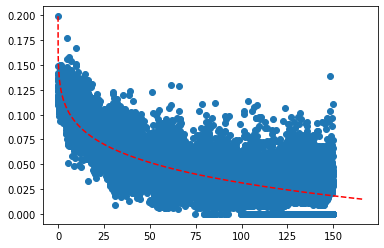

In [ ]:
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(0, max(delta_hours_list), 0.01)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
plt.scatter(np.linspace(0,150.01,15002), bitem_means)
plt.plot(x_line, y_line, '--', color='red')
plt.show()

####Modelo

In [ ]:
#Formula para ponderar la importancia de una vista segun pasan las horas

def time_weighing2(hours):
  if hours < 0.001:
    return 1
  bitem_prob = -a  + (delta_zero_prob - -b)/(1+(hours/c)**d)  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  weight = bitem_prob / delta_zero_prob  #bitem_prob para un delta de 0 hours clavado (ultimo item)
  return weight

In [ ]:
pred_y_model4 = []
def weighed_viewed_item(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing2(delta.total_seconds()/3600) #se convierte el delta en horas como float
  if items:  
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model4.append(weighed_viewed_item(row.user_history))

In [ ]:
pred_domain_model4 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model4]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model4))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model4))

accuracy producto predicho 0.1749115966337741
accuracy domain predicho 0.372361513494674


### Modelo 5 
Modelo 1, Multiplicando por la P(bitem)

In [ ]:
#Calculando P(item sea comprado) y creando un dict para lookup rápido
bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
total = len(train_df)
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
pred_y_model5 = []
def weighed_viewed_item_prob(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
  if items:
    for item in items:
      items[item] *= bitem_prob_dict.get(item,0)
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model5.append(weighed_viewed_item_prob(row.user_history))

In [ ]:
pred_domain_model5 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model5]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model5))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model5))

accuracy producto predicho 0.21340245859382376
accuracy domain predicho 0.4059729453024593


### Modelo 6: 10 items x predicción
Modelo 1, Multiplicando por la P(bitem). Se predicen los primeros 10 productos dentro de los vistos. 
En caso de que el usuario no haya visto 10 items unicos, se completa el resto con los items mas comprados de los dominios más vistos por el usuario.

In [ ]:
#TOP ITEMS POR DOMAIN
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)
top10_df = (train_df.groupby(['domain_id','item_bought']).count().
            sort_values(['domain_id','user_history'], ascending=False).
            reset_index(drop=False).groupby('domain_id').head(10))
top_10_items_by_domain = {}

for domain in top10_df.domain_id.unique():
  top_10_items_by_domain[domain] = [item for item in top10_df[top10_df.domain_id == domain]['item_bought']]

most_common_10 = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[:10]

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
bitem_count = train_df.groupby('item_bought').count()
bdom_count = train_df.groupby('domain_id').count()
bdom_list = bitem_count.index.tolist()
total = len(train_df)
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model6 = []


def find_next_item(domains_list,predictions):
  '''Encuentra el próximo item que aún no está en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  for domain in domains_list:
    for item in top_10_items_by_domain.get(domain,[]):  #Pueden haber domains vistos que no han sido comprados
      if item not in predictions:
        return item
  for item in most_common_10:
    if item not in predictions:
      return item

def weighed_time_prob_item_list(events_list):
  items_weight = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
  #Este if se utiliza porque hay usuarios que tienen 0 vistas.
  #Debe ser mejorado cuando se agregue NLP al análisis
  if items_weight:
    for item in items_weight:
      items_weight[item] *= bitem_prob_dict.get(item,0)

    #TO-DO evitar el overfitting que trae los items con prob=0 (nunca se podrá predecir la compra de algo que no fue comprado aun si no)
    top_viewed_items = sorted(items_weight, key=items_weight.get, reverse=True)[:10] #Puede devolver menos que 10 items, si el user vio menos que 10
    
    #Establecer prioridad entre los dominios vistos, para completar la recomendación del top10
    domain_weight_counter = {}
    for item in top_viewed_items:
      domain = item_domain_dict[item]
      if domain: #Hay algunos pocos elementos de los cuales no sabemos el domain
        domain_weight_counter[domain] = domain_weight_counter.get(domain,0) + 1 + items_weight[item]
    for domain in domain_weight_counter:
      domain_weight_counter[domain] *= bdom_prob_dict.get(domain,0) #Misma consideración respecto a items. Domains no comprados nunca seran top
    top_domains = sorted(domain_weight_counter, key=domain_weight_counter.get, reverse=True)
    
    #Generar las 10 predicciones
    #TO-DO> Pensar si conviene agregar un WEIGHT_THRESHOLD a partir del cual el item no será recomendado, y se recomendará en cambio algún item popular del top_domain
    top_10_predictions = top_viewed_items[:]
    for i in range(len(top_10_predictions),10):
      top_10_predictions.append(find_next_item(top_domains,top_10_predictions))
    return top_10_predictions
  else: #EL USER NO VIO NINGUN ITEM, SOLO SEARCHES
    return most_common_10

for row in train_df.itertuples():
 pred_y_model6.append(weighed_time_prob_item_list(row.user_history))

In [ ]:
#CALCULO DEL nDCG
def ndcg(predictions,bitem):
  ''' Dada una List de predictions, y un item comprado (int), devuelve el calculo de nDCG de la prediccion'''
  best = 22.4246159748234
  current = 0
  bdom = item_domain_dict[bitem]
  for i in range(1,11):
    pred = predictions[i-1]
    if pred == bitem:
      gain = 12
    elif item_domain_dict[pred] == bdom:
      gain = 1
    else:
      gain = 0
    current += (1/np.log(1+i)) * gain
  return current/best 

true_bitem = train_df.item_bought.tolist()
ndcg_list = []
for i in range(len(bitem_list)):
  ndcg_list.append(ndcg(pred_y_model6[i], true_bitem[i]))
  

In [ ]:
print('nDCG obtenido:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido: 0.2881922316870161


Performance en datos de TEST:

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model6 = []

for row in test_df.itertuples():
 pred_y_model6.append(weighed_time_prob_item_list(row.user_history))

In [ ]:
true_bitem = test_df.item_bought.tolist()
ndcg_list = []
for i in range(len(bitem_list)):
  ndcg_list.append(ndcg(pred_y_model6[i], true_bitem[i]))
  

In [ ]:
print('nDCG obtenido:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido: 0.281436584463679


### Hito 4: Modelo 7 - Knn: 10 items x predicción
Se adoptan 60.000 features (uno por item), con valores pesados según hace cuánto se vio cada vista. Se entrena un modelo de Knn Multiclase.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, ylist, test_size=0.20, random_state=4)

In [ ]:

from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100000, max_samples=10)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb=MultinomialNB()

In [ ]:

divs=5
for i in range(int(X_train.shape[0]/divs)):
 Xch=X_train[i*divs:(i+1)*divs-1]
 Ych= y_train[i*divs:(i+1)*divs-1]
 mnb.partial_fit(Xch,Ych, classes=np.unique(ylist))

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

knn.fit(X, ylist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
# X_train2, X_test2, y_train2, y_test2 =train_test_split(X_test, y_test, test_size=0.0001, random_state=4)

In [ ]:
pred = knn.predict_proba(X_test2)

In [ ]:
np.argsort(pred)

array([[    0, 40137, 40138, ..., 23339,  4488, 58486],
       [    0, 40138, 40139, ..., 14306, 55582,  4488],
       [    0, 40137, 40138, ..., 24321, 24771,  7039],
       ...,
       [    0, 40138, 40139, ..., 32626,  9116, 34997],
       [    0, 40137, 40138, ..., 40329, 18551, 40842],
       [    0, 40138, 40139, ..., 14306, 55582,  4488]])

In [ ]:
asd = np.array([3,1,2])
np.argsort(asd)

array([1, 2, 0])

In [ ]:
features_array = np.array(features)

In [ ]:
features_array[np.argsort(pred)][-10:]

array([[     33, 1404717, 1404815, ...,  819759,  159441, 2041072],
       [     33, 1404815, 1404831, ...,  508525, 1938604,  159441],
       [     33, 1404717, 1404815, ...,  851218,  866973,  252425],
       ...,
       [     33, 1404815, 1404831, ..., 1142577,  326212, 1226269],
       [     33, 1404717, 1404815, ..., 1410708,  656139, 1428655],
       [     33, 1404815, 1404831, ...,  508525, 1938604,  159441]])

In [ ]:
item_df[item_df.item_id == 852053]

,item_id,title,domain_id,product_id,price,category_id,condition
999968,852053,Plastica Dos Fios Selagem Térmica Marroquina +...,MLB-HAIR_TREATMENTS,None,29.99,MLB32130,new


In [ ]:
features_dict[2041072]

58486

In [ ]:
np.argmax(pred)

58486

In [ ]:
asd[np.argsort(asd)]

array([1, 2, 3])

### Hito 4: Modelo 6 a esparsa para aplicar Machine Learning

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

# pred_y_model6 = []


def find_next_item(domains_list,predictions):
  '''Encuentra el próximo item que aún no está en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  for domain in domains_list:
    for item in top_10_items_by_domain.get(domain,[]):  #Pueden haber domains vistos que no han sido comprados
      if item not in predictions:
        return item
  for item in most_common_10:
    if item not in predictions:
      return item

def weighed_time_prob_item_list_sparse_matrix(events_list, data,cols):
  items_weight = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
  #Este if se utiliza porque hay usuarios que tienen 0 vistas.
  #Debe ser mejorado cuando se agregue NLP al análisis
  #Armar la matriz esparsa de X
#Esta matriz toma las consideraciones del Modelo 1 respecto a la ponderación por tiempo
#No es utilizada en el resto del Notebook, pero se deja aquí para mostrar el intento
#de mejorar el modelo con Scikit_Learn
  items = 0
  for item in items_weight:
    if item in features_dict: #Solo se suman los items que fueron comprados alguna vez
      items += 1
      cols.append(features_dict.get(item))
      data.append(items_weight[item])
  return items

rows = []
cols = []
data = []
i=0
for row in train_df.itertuples():  
  for it in range(weighed_time_prob_item_list_sparse_matrix(row.user_history,data,cols)):
    rows.append(i)
  i += 1

In [ ]:
# Import required package
import numpy as np
from scipy.sparse import csc_matrix
  
# creating sparse matrix
X = csc_matrix((data, (rows, cols)),
                          shape = (len(train_df), len(features)))
  
X

<413163x64928 sparse matrix of type '<class 'numpy.float64'>'
	with 966726 stored elements in Compressed Sparse Column format>

In [ ]:
ylist = train_df['item_bought'].astype(str).tolist()

In [ ]:
with open('y_list_simple.txt', 'w') as f:
    for item in ylist:
        f.write("%s\n" % item)
import scipy.sparse
scipy.sparse.save_npz('X_sparse_simple.npz', X)
# scipy.sparse.save_npz('y_sparse.npz', y)

In [ ]:
from google.colab import files
files.download('X_sparse_simple.npz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, ylist, test_size=0.20, random_state=4)

In [ ]:
def shuffle_sparse(X_matrix, y_matrix):
    index = np.arange(np.shape(X_matrix)[0])
    np.random.shuffle(index)
    return X_matrix[index, :], np.array(y_matrix)[index]
def batches(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
import random
clf2 = SGDClassifier() # shuffle=True is useless here
# shuffledRange = range(x_train.shape[0])
n_iter = 5
for n in range(n_iter):
    shuffledX, shuffledY = shuffle_sparse(X_train, y_train)
    for batch in batches(range(shuffledX.shape[0]), 10):
        clf2.partial_fit(shuffledX[batch[0]:batch[-1]+1], shuffledY[batch[0]:batch[-1]+1], classes=np.unique(y_train))

### Hito 4: Utilización de SEARCHS --> DOM
Utilizamos NLTK y fasttext para crear un modelo que con cada Search, prediga el Dominio que el usuario intentó buscar.

#### Armado modelo ft

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
' '.join([word for word in item_df.title[0].split(' ') if word not in ['hola']]).replace(',','').replace('.','')

'Casa Sola En Venta Con Gran Patio Solo Pago De Contado'

In [ ]:
item_df.head(1)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new


In [ ]:
from sklearn.model_selection import train_test_split

item_train,item_test=train_test_split(item_df, test_size=0.20, random_state=4)

In [ ]:

stopwords_sp = stopwords.words("spanish")
stopwords_po = stopwords.words("portuguese") 
corpus = ''

for row in item_train.itertuples():
  spanish = row.category_id[2:3] == 'M'  ##M == MEXICO
  if row.domain_id:
    if spanish:
      title = ' '.join([word for word in row.title.split(' ') if word not in stopwords_sp]).replace(',','').replace('.','')
      doc = '__label__' + row.domain_id + ' ' + title + '\n'
    else:
      title = ' '.join([word for word in row.title.split(' ') if word not in stopwords_po]).replace(',','').replace('.','')
      doc = '__label__' + row.domain_id + ' ' + title + '\n'
    corpus += doc


In [ ]:
corpus_test = ''

for row in item_test.itertuples():
  spanish = row.category_id[2:3] == 'M'  ##M == MEXICO
  if row.domain_id:
    if spanish:
      title = ' '.join([word for word in row.title.split(' ') if word not in stopwords_sp]).replace(',','').replace('.','')
      doc = '__label__' + row.domain_id + ' ' + title + '\n'
    else:
      title = ' '.join([word for word in row.title.split(' ') if word not in stopwords_po]).replace(',','').replace('.','')
      doc = '__label__' + row.domain_id + ' ' + title + '\n'
    corpus_test += doc


In [ ]:
with open('item_test_20.txt', 'w', encoding="utf-8") as f:
  f.write('%s' % corpus_test)

In [ ]:
with open('item_train_80.txt', 'w', encoding="utf-8") as f:
  f.write('%s' % corpus)

In [ ]:
import fasttext
model=fasttext.train_supervised(input='item_train_80.txt', epoch=10, wordNgrams=2)

In [ ]:
model.save_model("model_filename.bin")

In [ ]:
from google.colab import files
files.download('model_filename.bin')

#### Análisis de modelo ft - UBA

In [ ]:
#MODEL
!gdown https://drive.google.com/u/0/uc?id=1dgnKkzvWNCEE9odKcXqFfBTK1Q6-4bgy&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1dgnKkzvWNCEE9odKcXqFfBTK1Q6-4bgy
To: /content/ftmodel_ngrams2_lr05_epoch15.bin
1.01GB [00:08, 116MB/s]


In [ ]:
import fasttext
ft_model = fasttext.load_model('/content/ftmodel_ngrams2_lr05_epoch15.bin')

In [ ]:
for i in [384344,102455,408680,56612,207299]:
  for event in train_df.user_history[i]:
    if event['event_type'] == 'search':
      print(event['event_info'], ft_model.predict(event['event_info'].title()))

#### Entrenamiento curvas ponderación Searchs

Precarga predict(train searches), random_state=4, por temas de tiempo (tarda aprox 2:30hs en predecir todo el train_dataset con 4.8M de searches). 

In [ ]:
!gdown https://drive.google.com/u/1/uc?id=1LeHQUMjVAJWd6Gh069y8YbI9a-rJ6fg9&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=1LeHQUMjVAJWd6Gh069y8YbI9a-rJ6fg9
To: /content/trees_dict.pkl
3.37MB [00:00, 107MB/s]


In [ ]:
!gdown https://drive.google.com/u/1/uc?id=18GhEyLh-DZLJbDnmuizjhH74bB1lZnwR&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=18GhEyLh-DZLJbDnmuizjhH74bB1lZnwR
To: /content/test_searches_doms.txt
23.9MB [00:00, 147MB/s]


In [ ]:
!gdown https://drive.google.com/u/1/uc?id=1-T5yhfTKS33nqVUw_U23tt5Ru7YhtmNC&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=1-T5yhfTKS33nqVUw_U23tt5Ru7YhtmNC
To: /content/train_searches_doms.txt
95.1MB [00:00, 109MB/s]


In [ ]:
with open('/content/train_searches_doms.txt') as f:
    train_searches_doms = f.read().splitlines()

In [ ]:
with open('/content/test_searches_doms.txt') as f:
    test_searches_doms = f.read().splitlines()

In [ ]:
ft_model.predict('cuaderno dibujo')[0][0][9:].title()

'Mlb-Unclassified_Products'

In [ ]:
#De momento no miramos las stopwords, debido a que el modelo se entrenó sin stopwords en minúsculas, pero la mayoría de las palabras estaban en mayúsculas...
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# stopwords_sp_po = stopwords.words("portuguese")  + stopwords.words("spanish") 
deltas_list = []
bdom_list = []
for row in train_df.itertuples():
  bdom = item_domain_dict[row.item_bought]
  most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in row.user_history:
    if event['event_type'] == 'search':
        deltas_list.append(most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z'))
        # clean_string = ' '.join([word.capitalize() for word in event['event_info'].split(' ') if word not in stopwords_sp_po]).replace(',','').replace('.','').replace('\n','')
        clean_string = event['event_info'].replace(',','').replace('.','').replace('\n','').title()
        bdom_list.append(int(ft_model.predict(clean_string)[0][0][9:] == bdom))
delta_hours_list = [delta.total_seconds()/60/60 for delta in deltas_list]

In [ ]:
delta_bdom_df = pd.DataFrame({'deltas':delta_hours_list, 'bdom':bdom_list})

In [ ]:
delta_zero_prob = delta_bdom_df[delta_bdom_df.deltas == 0].bdom.mean()
delta_zero_prob

0.18291818273898106

In [ ]:
salto = np.linspace(0,150,15001)[1] - np.linspace(0,150,15001)[0]
bdom_means = [delta_zero_prob]
for hs in np.linspace(0,150,15001):
  bdom_means.append(delta_bdom_df[(delta_bdom_df.deltas>hs)&(delta_bdom_df.deltas<=(hs+salto))].bdom.mean())

In [ ]:
from scipy.optimize import curve_fit
# define the true objective function
#-2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)
def objective(x, a, b, c, d):
	return -a  + (delta_zero_prob - -b)/(1+(x/c)**d)
#Se agrega peso al primer punto, para asegurar que la curva pase por el mismo
y_weight = np.empty(len(bdom_means))
y_weight.fill(10)
# y_weight[0] = 0.001      	SE QUITA EL MAYOR PESO DEL PRIMER PUNTO (DELTA=0), PORQUE ESTAMOS TRABAJANDO CON DOMAIN Y CON SEARCH, QUE NO TIENE TANTA DEPENDENCIA LO ULTIMISIMO QUE BUSQUE CON LO QUE COMPRÉ
# curve fit									SI LE PONEMOS WEIGHT AL PRIMER PUNTO, LA CURVA QUE QUEDA NO ACOMPAÑA LOS PUNTOS GRAFICADOS
popt, _ = curve_fit(objective, np.linspace(0,150.01,15002), bdom_means, sigma=y_weight, absolute_sigma=True)
# summarize the parameter values
a, b, c, d = popt
a, b, c, d

(-0.07681675578181439,
 0.011361452124463566,
 31.016236279981843,
 1.3218751870258658)

In [ ]:
objective(0,a,b,c,d)

0.27109639064525903

In [ ]:
#a = -0.07681675578181439
# b = 0.011361452124463566
# c = 31.016236279981843
# d = 1.3218751870258658

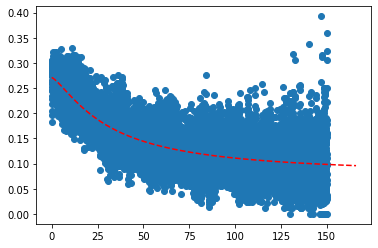

In [ ]:
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(0, max(delta_hours_list), 0.01)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
plt.scatter(np.linspace(0,150.01,15002), bdom_means)
plt.plot(x_line, y_line, '--', color='red')
plt.show()

In [ ]:
#Formula para ponderar la importancia de una SEARCH segun pasan las horas
def search_time_weighing(hours):
  a = -0.07681675578181439
  b = 0.011361452124463566  
  c = 31.016236279981843
  d = 1.3218751870258658
  delta_zero_prob = 0.18291818273898106
  if hours < 0.001:
    return 1
  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  #Esta curva se calculó con una mezcla de python + otro soft online. Al final de esta notebook, en el
  #modelo 4, se muestra el método de cálculo 100% dentro de python, que arroja el mismo resultado
  search_bdom_prob = -a  + (delta_zero_prob - -b)/(1+(hours/c)**d)
  # search_bdom_prob = -2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)  
  weight = search_bdom_prob / 0.27109639064525903  #el número es la funcion evaluada en hours=0
  return weight

In [ ]:
bdom_searches_weights = []
bdoms_searched = []
# train_searches_doms = []  SIN PRECARGA
progress = 0
i = 0                      #CON PRECARGA
for row in train_df.itertuples():
  if progress % 10000 == 0:
    print(progress)
  progress +=1
  
  weight = 0
  bdom = item_domain_dict[row.item_bought]

  most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in row.user_history:
    if event['event_type'] == 'search':
      # clean_string = event['event_info'].replace(',','').replace('.','').replace('\n','').title()     SIN PRECARGA
      # event_dom = ft_model.predict(clean_string)[0][0][9:]                                            SIN PRECARGA
      # train_searches_doms.append(event_dom)                                                           SIN PRECARGA
      event_dom = train_searches_doms[i]                                                               #CON PRECARGA
      i+=1
    if event_dom == bdom:
      weight += search_time_weighing((most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')).total_seconds()/60/60)
        
  bdoms_searched.append(bdom)
  bdom_searches_weights.append(weight)

In [ ]:
#PARA ARMAR PRECARGA

# with open('train_searches_doms.txt', 'w') as f:
#     for item in train_searches_doms:
#         f.write("%s\n" % item)

In [ ]:
bdom_searches_weights_df = pd.DataFrame({'bdoms':bdoms_searched, 'bdom_searches_weights':bdom_searches_weights})
bdom_searches_weights_df.head(3)

,bdoms,bdom_searches_weights
0,MLB-SPEAKERS,0.0
1,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,0.0
2,MLB-GARDENING_AND_AGRICULTURE_SEEDS,0.0


In [ ]:
#Distribución de los cuantiles de weights de searches del dominio, según dominio
bdom_searches_weights_df[bdom_searches_weights_df.bdom_searches_weights > 0].groupby('bdoms').quantile(q=0.5).describe()

,bdom_searches_weights
count,2064.000000
mean,9.792610
std,7.922221
min,0.567940
25%,5.508426
50%,8.345769
75%,11.678062
max,198.020156


In [ ]:
#Lo convertimos en un DICT
bdom_searches_weights_50q_dict = bdom_searches_weights_df[bdom_searches_weights_df.bdom_searches_weights > 0].groupby('bdoms').quantile(q=0.5).bdom_searches_weights.to_dict()

####Análisis influencia searches -> bdom

In [ ]:
bdoms = []
searches = []
views = []
# s_div_v = []
i=0
for row in train_df.itertuples():
  bdom = item_domain_dict[row.item_bought]
  view_dom_count = {}
  search_dom_count = {}
  for event in row.user_history:
    if event['event_type'] == 'view':
      item_dom = item_domain_dict[event['event_info']]
      if item_dom:
        view_dom_count[item_dom] = view_dom_count.get(item_dom,0) + 1
    else:
      item_dom = train_searches_doms[i]
      i += 1
      search_dom_count[item_dom] = search_dom_count.get(item_dom,0) + 1
  for dom in set(list(view_dom_count.keys()) + list(search_dom_count.keys())):
    bdoms.append(dom==bdom)
    searches.append(search_dom_count.get(dom,0))
    views.append(view_dom_count.get(dom,0))


In [ ]:
searches_analysys_df = pd.DataFrame({'searches':searches, 'views':views, 'bdoms':bdoms})
searches_analysys_df.head(3)

,searches,views,bdoms
0,0,3,False
1,5,1,False
2,0,2,False


In [ ]:
searches_analysys_df['s_over_v'] = searches_analysys_df.searches / searches_analysys_df.views

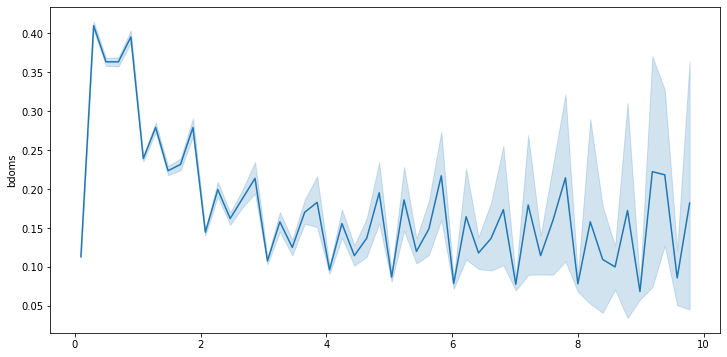

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=[(a.left + a.right)/2 for a in pd.cut(searches_analysys_df[searches_analysys_df.s_over_v < 10].s_over_v,50)], y=searches_analysys_df[searches_analysys_df.s_over_v < 10].bdoms, ax=ax)

Conforme aumenta la relación SEARCHES de un DOM / VIEWS de un DOM, disminuye la chance de que se compre algo de ese DOM.
Esto tiene sentido: Si uno busca muchas veces algo, y no entra a ver los items, es porque no está encontrando lo que busca, o porque no está interesado en comprar sino en ver qué existe en el mercado.

In [ ]:
bdoms = []
searches = []
views = []
# s_div_v = []
i=0
for row in train_df.itertuples():
  bdom = item_domain_dict[row.item_bought]
  view_dom_weight = {}
  search_dom_weight = {}
  most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in row.user_history:
    delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    if event['event_type'] == 'view':
      item_dom = item_domain_dict[event['event_info']]
      if item_dom:
        view_dom_weight[item_dom] = view_dom_weight.get(item_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
    else:
      item_dom = train_searches_doms[i]
      i += 1
      search_dom_weight[item_dom] = search_dom_weight.get(item_dom,0) + search_time_weighing(delta.total_seconds()/3600)
  for dom in set(list(view_dom_weight.keys()) + list(search_dom_weight.keys())):
    bdoms.append(dom==bdom)
    searches.append(search_dom_weight.get(dom,0))
    views.append(view_dom_weight.get(dom,0))

In [ ]:
searches_analysys2_df = pd.DataFrame({'searches':searches, 'views':views, 'bdoms':bdoms})
searches_analysys2_df.head(3)

,searches,views,bdoms
0,14.760092,5.259678,False
1,0.000000,0.397691,False
2,7.026353,0.000000,False


In [ ]:
searches_analysys2_df['s_over_v'] = searches_analysys2_df.searches / searches_analysys2_df.views

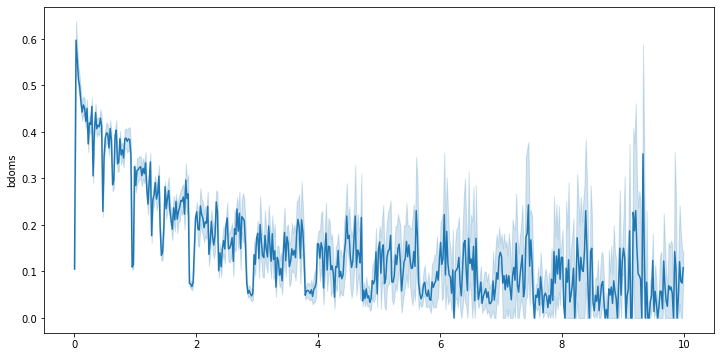

In [ ]:
#Weighed searches/views:

fig, ax = plt.subplots(figsize=(12,6))
cuts=500
max = 10
sns.lineplot(x=[(a.left + a.right)/2 for a in pd.cut(searches_analysys2_df[searches_analysys2_df.s_over_v < max].s_over_v,cuts)], y=searches_analysys2_df[searches_analysys2_df.s_over_v < max].bdoms, ax=ax)

In [ ]:
searches_analysys2_df[searches_analysys2_df.s_over_v > 0].bdoms.mean()

0.10523304903711492

In [ ]:
len(searches_analysys2_df[searches_analysys2_df.s_over_v == 0]), len(searches_analysys2_df[searches_analysys2_df.s_over_v > 0])

(690477, 843899)

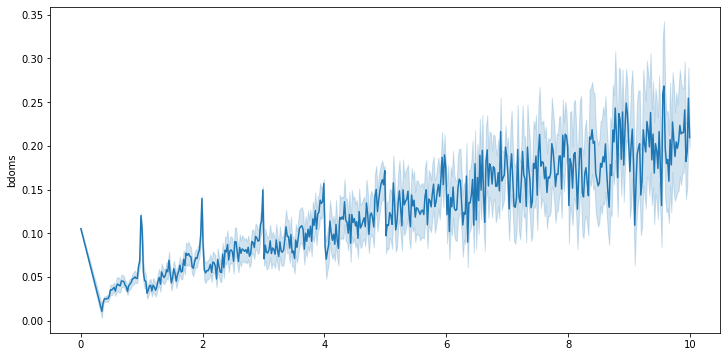

In [ ]:
#Weighed searches:

fig, ax = plt.subplots(figsize=(12,6))
cuts=500
max = 10
sns.lineplot(x=[(a.left + a.right)/2 for a in pd.cut(searches_analysys2_df[searches_analysys2_df.searches < max].searches,cuts)], y=searches_analysys2_df[searches_analysys2_df.searches < max].bdoms, ax=ax)

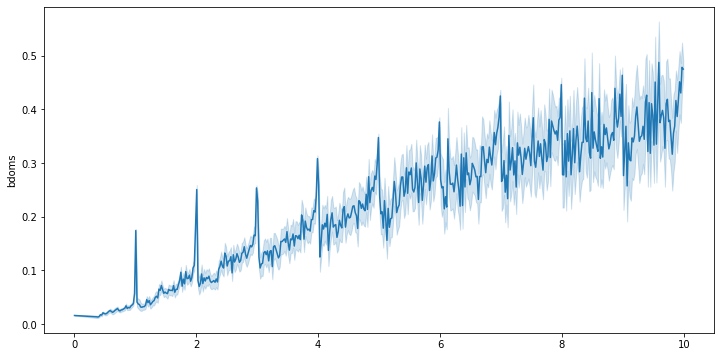

In [ ]:
#Weighed views:

fig, ax = plt.subplots(figsize=(12,6))
cuts=500
max = 10
sns.lineplot(x=[(a.left + a.right)/2 for a in pd.cut(searches_analysys2_df[searches_analysys2_df.views < max].views,cuts)], y=searches_analysys2_df[searches_analysys2_df.views < max].bdoms, ax=ax)

####Creación Modelo para ver impacto de searches

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
X = searches_analysys2_df[searches_analysys2_df.views>0][['searches','views','s_over_v']]
y = searches_analysys2_df[searches_analysys2_df.views>0].bdoms
# from sklearn.svm import SVC
# clf = make_pipeline(RobustScaler(), SVC())
# clf.fit(X, y)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree =  DecisionTreeClassifier(min_samples_split=10000, random_state=4)
tree.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4, splitter='best')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(searches_analysys2_df[searches_analysys2_df.views>0].bdoms, tree.predict(searches_analysys2_df[searches_analysys2_df.views>0][['searches','views','s_over_v']]))

0.8535897994562489

In [ ]:
from joblib import dump, load
dump(tree, 'search_views_tree_classifier.joblib') 

['search_views_tree_classifier.joblib']

#### Curvas ponderación bdom_views según domain:

In [ ]:
deltas_list_doms = []
bdom_views_list = []
for row in train_df.itertuples():
  bdom = item_domain_dict[row.item_bought]
  most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in row.user_history:
    if event['event_type'] == 'view':
        deltas_list_doms.append(most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z'))
        # clean_string = ' '.join([word.capitalize() for word in event['event_info'].split(' ') if word not in stopwords_sp_po]).replace(',','').replace('.','').replace('\n','')
        # clean_string = event['event_info'].replace(',','').replace('.','').replace('\n','').title()
        bdom_views_list.append(int(item_domain_dict[event['event_info']] == bdom))
delta_hours_list_doms = [delta.total_seconds()/60/60 for delta in deltas_list_doms]

In [ ]:
delta_bdom_views_df = pd.DataFrame({'deltas':delta_hours_list_doms, 'bdom':bdom_views_list})

In [ ]:
delta_zero_prob = delta_bdom_views_df[delta_bdom_views_df.deltas == 0].bdom.mean()
delta_zero_prob

0.41044942208681806

In [ ]:
salto = np.linspace(0,150,15001)[1] - np.linspace(0,150,15001)[0]
bdom_views_means = [delta_zero_prob]
for hs in np.linspace(0,150,15001):
  bdom_views_means.append(delta_bdom_views_df[(delta_bdom_views_df.deltas>hs)&(delta_bdom_views_df.deltas<=(hs+salto))].bdom.mean())

In [ ]:
from scipy.optimize import curve_fit
# define the true objective function
#-2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)
def objective(x, a, b, c, d):
	return -a  + (delta_zero_prob - -b)/(1+(x/c)**d)
#Se agrega peso al primer punto, para asegurar que la curva pase por el mismo
y_weight = np.empty(len(bdom_means))
y_weight.fill(10)
# y_weight[0] = 0.001      	SE QUITA EL MAYOR PESO DEL PRIMER PUNTO (DELTA=0), PORQUE ESTAMOS TRABAJANDO CON DOMAIN Y CON SEARCH, QUE NO TIENE TANTA DEPENDENCIA LO ULTIMISIMO QUE BUSQUE CON LO QUE COMPRÉ
# curve fit									SI LE PONEMOS WEIGHT AL PRIMER PUNTO, LA CURVA QUE QUEDA NO ACOMPAÑA LOS PUNTOS GRAFICADOS
popt, _ = curve_fit(objective, np.linspace(0,150.01,15002), bdom_views_means, sigma=y_weight, absolute_sigma=True)
# summarize the parameter values
a, b, c, d = popt
a, b, c, d

(-0.12327030225662998,
 -0.09520322003097634,
 36.15114795111291,
 1.373571429102444)

In [ ]:
objective(0,a,b,c,d)

0.43851650431247174

In [ ]:
# a = -0.12327030225662998,
# b =  -0.09520322003097634,
# c =  36.15114795111291,
# d =  1.373571429102444

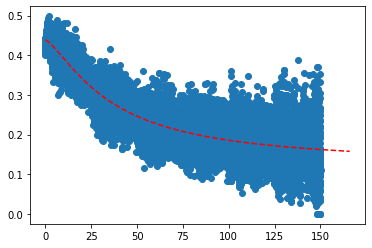

In [ ]:
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(0, max(delta_hours_list), 0.01)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
plt.scatter(np.linspace(0,150.01,15002), bdom_views_means)
plt.plot(x_line, y_line, '--', color='red')
plt.show()

In [ ]:
#Formula para ponderar la importancia de una SEARCH segun pasan las horas
def dom_view_time_weighing(hours):
  a = -0.12327030225662998
  b =  -0.09520322003097634
  c =  36.15114795111291
  d =  1.373571429102444
  delta_zero_prob = 0.41044942208681806
  if hours < 0.001:
    return 1
  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  #Esta curva se calculó con una mezcla de python + otro soft online. Al final de esta notebook, en el
  #modelo 4, se muestra el método de cálculo 100% dentro de python, que arroja el mismo resultado
  search_bdom_prob = -a  + (delta_zero_prob - -b)/(1+(hours/c)**d)
  # search_bdom_prob = -2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)  
  weight = search_bdom_prob / 0.43851650431247174  #el número es la funcion evaluada en hours=0
  return weight

In [ ]:
bdom_views_weights = []
bdoms = []
for row in train_df.itertuples():
  weight = 0
  bdom = item_domain_dict[row.item_bought]

  most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in row.user_history:
    if event['event_type'] == 'view':
      if item_domain_dict[event['event_info']] == bdom:
        weight += dom_view_time_weighing((most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')).total_seconds()/60/60)
        
  bdoms.append(bdom)
  bdom_views_weights.append(weight)

In [ ]:
bdom_weights_df = pd.DataFrame({'bdoms':bdoms, 'bdom_views_weights':bdom_views_weights})
bdom_weights_df.head(3)

,bdoms,bdom_views_weights
0,MLB-SPEAKERS,0.0
1,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,0.0
2,MLB-GARDENING_AND_AGRICULTURE_SEEDS,0.0


Quito las filas con bdom_views == 0, ya que esto lo voy a utilizar para ponderar bdom_views concretas, es decir, todos casos donde dom_view > 0, con la asunción implícita de que eso permite predecir el bdom.

In [ ]:
bdom_weights_50q_dict = bdom_weights_df[bdom_weights_df.bdom_views_weights > 0].groupby('bdoms').quantile(q=0.5).bdom_views_weights.to_dict()

Armado de diccionario bdom --> 75% quantile de time_weighed dom_views:

In [ ]:
bdom_weights_75q_dict = bdom_weights_df.groupby('bdoms').quantile(q=0.75).bdom_views_weights.to_dict()

Se toma el quantile 75%, ya que el 50% de las compras se ralizan sin mirar el domain de la compra. 75% es la mitad entre 50 y 100. De todos modos, el objetivo es comparar a los domains entre sí, y se aplica el mismo porcentaje para todos los domains.

#### Modelo 8:
Modelo 6, agregando sinergia para items de domains con muchas vistas. 
No se utilizan las search.

In [ ]:
#TOP ITEMS POR DOMAIN
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)
top10_df = (train_df.groupby(['domain_id','item_bought']).count().
            sort_values(['domain_id','user_history'], ascending=False).
            reset_index(drop=False).groupby('domain_id').head(10))
top_10_items_by_domain = {}

for domain in top10_df.domain_id.unique():
  top_10_items_by_domain[domain] = [item for item in top10_df[top10_df.domain_id == domain]['item_bought']]

most_common_10 = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[:10]

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
bitem_count = train_df.groupby('item_bought').count()
bdom_count = train_df.groupby('domain_id').count()
bdom_list = bitem_count.index.tolist()
total = len(train_df)
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
total = len(train_df)

bdom_count = train_df.groupby('domain_id').count()
bdom_list = bdom_count.index.tolist()
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))

bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model8 = []


def find_next_item(domains_list,predictions):
  '''Encuentra el próximo item que aún no está en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  for domain in domains_list:
    for item in top_10_items_by_domain.get(domain,[]):  #Pueden haber domains vistos que no han sido comprados
      if item not in predictions:
        return item
  for item in most_common_10:
    if item not in predictions:
      return item

def model_8(events_list,strength=1.5):
  DOM_SYNERGY_STRENGTH = strength
  #Modelo con:  acumulación de vistas, pesadas según tiempo
              # sinergia entre domains con muchas vistas, pesado según tiempo, y según tipo de domain
  items_weight = {}
  domains_weight = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      #Además, se agrega un contador de vistas del dominio (ponderada por time_delta) para luego agregarle peso a los items de los domains mas vistos
      event_dom = item_domain_dict[event['event_info']]
      if event_dom:
        domains_weight[event_dom] = domains_weight.get(event_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
        
  #Este if se utiliza porque hay usuarios que tienen 0 vistas.
  #Debe ser mejorado cuando se agregue NLP al análisis
  if items_weight:
    for item in items_weight:
      item_dom = item_domain_dict[item]
      if item_dom:
        bdom_weights_50q = bdom_weights_50q_dict.get(item_dom, 0)
        if bdom_weights_50q > 0:
          items_weight[item] *=  domains_weight[item_dom] / bdom_weights_50q * DOM_SYNERGY_STRENGTH
      items_weight[item] *= bitem_prob_dict.get(item,0)

    #TO-DO evitar el overfitting que trae los items con prob=0 (nunca se podrá predecir la compra de algo que no fue comprado aun si no)
    top_viewed_items = sorted(items_weight, key=items_weight.get, reverse=True)[:10] #Puede devolver menos que 10 items, si el user vio menos que 10
    
    #Establecer prioridad entre los dominios vistos DE LOS ITEMS ELEGIDOS, para completar la recomendación del top10
    domain_weight_counter = {}
    for item in top_viewed_items:
      domain = item_domain_dict[item]
      if domain: #Hay algunos pocos elementos de los cuales no sabemos el domain
        domain_weight_counter[domain] = domain_weight_counter.get(domain,0) + 1 + items_weight[item]
    for domain in domain_weight_counter:
      domain_weight_counter[domain] *= 0#bdom_prob_dict.get(domain,0) #Misma consideración respecto a items. Domains no comprados nunca seran top
    top_domains = sorted(domain_weight_counter, key=domain_weight_counter.get, reverse=True)
    
    #Generar las 10 predicciones
    #TO-DO> Pensar si conviene agregar un WEIGHT_THRESHOLD a partir del cual el item no será recomendado, y se recomendará en cambio algún item popular del top_domain
    top_10_predictions = top_viewed_items[:]
    for i in range(len(top_10_predictions),10):
      top_10_predictions.append(find_next_item(top_domains,top_10_predictions))
    return top_10_predictions
  else: #EL USER NO VIO NINGUN ITEM, SOLO SEARCHES
    return most_common_10

for row in train_df.itertuples():
 pred_y_model8.append(model_8(row.user_history))

In [ ]:
#CALCULO DEL nDCG
def ndcg(predictions,bitem):
  ''' Dada una List de predictions, y un item comprado (int), devuelve el calculo de nDCG de la prediccion'''
  best = 22.4246159748234
  current = 0
  bdom = item_domain_dict[bitem]
  for i in range(1,11):
    pred = predictions[i-1]
    if pred == bitem:
      gain = 12
    elif item_domain_dict[pred] == bdom:
      gain = 1
    else:
      gain = 0
    current += (1/np.log(1+i)) * gain
  return current/best 

true_bitem = train_df.item_bought.tolist()
ndcg_list = []
for i in range(len(true_bitem)):
  ndcg_list.append(ndcg(pred_y_model8[i], true_bitem[i]))
  

In [ ]:
print('nDCG obtenido:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido: 0.28792895157424725


In [ ]:
print('nDCG obtenido STRENGTH=0.05:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=0.05: 0.2859151235916065


In [ ]:
print('nDCG obtenido STRENGTH=0.5, nueva fórmula doms:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=0.05, nueva fórmula doms: 0.29010672188150344


In [ ]:
print('nDCG obtenido STRENGTH=0.25, nueva fórmula doms:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=0.25, nueva fórmula doms: 0.2900598524006226


In [ ]:
print('nDCG obtenido STRENGTH=1, nueva fórmula doms:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=1, nueva fórmula doms: 0.29013290338964337


In [ ]:
print('nDCG obtenido STRENGTH=2, nueva fórmula doms:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=2, nueva fórmula doms: 0.29014534194435654


In [ ]:
print('nDCG obtenido STRENGTH=1.5, nuevo bdom_prob:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=1.5, nuevo bdom_prob: 0.2680346916490222


In [ ]:
print('nDCG obtenido STRENGTH=1.5, nuevo bdom_prob=0:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido STRENGTH=1.5, nuevo bdom_prob=0: 0.26730413879231685


Búsqueda de hiperparámetro Strength óptimo (tras ajustes a la forma de ponderar las vistas de dominio):

In [ ]:
true_bitem = train_df.item_bought.tolist()
true_bitem_test = test_df.item_bought.tolist()
for strength in [1,0.25,0.5,1.5,2]:
  #TRAIN
  pred_y_model8 = []
  for row in train_df.itertuples():
    pred_y_model8.append(model_8(row.user_history,strength))

  ndcg_list = []
  for i in range(len(true_bitem)):
    ndcg_list.append(ndcg(pred_y_model8[i], true_bitem[i]))
 
  #TEST:
  pred_y_model8_test = []
  for row in test_df.itertuples():
    pred_y_model8_test.append(model_8(row.user_history,strength))
  
  ndcg_list_test = []
  for i in range(len(true_bitem_test)):
    ndcg_list_test.append(ndcg(pred_y_model8_test[i], true_bitem_test[i]))
  print('STRENGTH=',strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
  print('STRENGTH=',strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

STRENGTH= 1 nDCG TRAIN= 0.29026293085829347
STRENGTH= 1 nDCG TEST = 0.28376705688286674
STRENGTH= 0.25 nDCG TRAIN= 0.29023834803665177
STRENGTH= 0.25 nDCG TEST = 0.2837535351278437
STRENGTH= 0.5 nDCG TRAIN= 0.29025167517482786
STRENGTH= 0.5 nDCG TEST = 0.2837635886061157
STRENGTH= 1.5 nDCG TRAIN= 0.2902675175765638
STRENGTH= 1.5 nDCG TEST = 0.2837733278065142
STRENGTH= 2 nDCG TRAIN= 0.29026993813738367
STRENGTH= 2 nDCG TEST = 0.2837733122514765


Se adopta STRENGTH = 1.5

Performance en datos de TEST:

In [ ]:
pred_y_model8_test = []
for row in test_df.itertuples():
 pred_y_model8_test.append(model_8(row.user_history))

In [ ]:
true_bitem_test = test_df.item_bought.tolist()
ndcg_list_test = []
for i in range(len(true_bitem_test)):
  ndcg_list_test.append(ndcg(pred_y_model8_test[i], true_bitem_test[i]))
print('nDCG obtenido STRENGTH=2, nueva fórmula doms:' , sum(ndcg_list_test) / len(ndcg_list_test))

nDCG obtenido STRENGTH=2, nueva fórmula doms: 0.2837382273387152


#### Modelo 9: Modelo 8 + Searchs
Modelo 8 = Vistas ponderadas por tiempo + Vistas de Dominio ponderadas por tiempo y por tipo de dominio

Modelo 9 = Todo lo anterior + Searches de Dominio ponderadas por tiempo y por tipo de dominio

In [ ]:
#TOP ITEMS POR DOMAIN
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)
top10_df = (train_df.groupby(['domain_id','item_bought']).count().
            sort_values(['domain_id','user_history'], ascending=False).
            reset_index(drop=False).groupby('domain_id').head(10))
top_10_items_by_domain = {}

for domain in top10_df.domain_id.unique():
  top_10_items_by_domain[domain] = [item for item in top10_df[top10_df.domain_id == domain]['item_bought']]

most_common_10 = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[:10]

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
total = len(train_df)

bdom_count = train_df.groupby('domain_id').count()
bdom_list = bdom_count.index.tolist()
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))

bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model9 = []


def find_next_item(domains_list,predictions):
  '''Encuentra el próximo item que aún no está en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  for domain in domains_list:
    for item in top_10_items_by_domain.get(domain,[]):  #Pueden haber domains vistos que no han sido comprados
      if item not in predictions:
        return item
  for item in most_common_10:
    if item not in predictions:
      return item

def model_9(events_list,strength=1.5, search_strength=1,search_preload=None,preload_index=0):
  DOM_SYNERGY_STRENGTH = strength
  SEARCH_STRENGTH = search_strength
  #Modelo con:  acumulación de vistas, pesadas según tiempo
              # sinergia entre domains con muchas vistas, pesado según tiempo, y según tipo de domain 
              # + SEARCHES DE DOMINIO pesadas según tiempo y según tipo de domain

  items_weight = {}
  domains_weight = {}
  search_doms_weights = {}
  i = preload_index                 #CON PRECARGA PREDICT(SEARCH)

  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  ###VISTAS:
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    if event['event_type'] == 'view':
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      #Además, se agrega un contador de vistas del dominio (ponderada por time_delta) para luego agregarle peso a los items de los domains mas vistos
      event_dom = item_domain_dict[event['event_info']]
      if event_dom:
        domains_weight[event_dom] = domains_weight.get(event_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
    ###SEARCHES DE DOMAIN
    else:   
      search_dom = search_preload[i]        #CON PRECARGA PREDICT(SEARCH)
      i +=1                                 #CON PRECARGA PREDICT(SEARCH)
      search_doms_weights[search_dom] = search_doms_weights.get(search_dom,0) + search_time_weighing(delta.total_seconds()/3600)

  for dom in domains_weight:
    domains_weight[dom] *= bdom_prob_dict.get(dom,0)
  for dom in search_doms_weights:
    search_doms_weights[dom] *= bdom_prob_dict.get(dom,0)
  viewed_items_doms = []
  for item in items_weight:
    item_dom = item_domain_dict[item]
    if item_dom and item_dom not in viewed_items_doms:
      viewed_items_doms.append(item_dom)
  
  #Calculamos la prob total de comprar tal o cual domain, para 
  total_viewed_doms_weight = 0
  total_searched_doms_weight = 0
  for dom in viewed_items_doms:
    total_viewed_doms_weight += domains_weight.get(dom,0)
    total_searched_doms_weight += search_doms_weights.get(dom,0)
  
  for item in items_weight:
    item_dom = item_domain_dict[item]
    if item_dom:
      #FACTOR PESO DE VISTAS DE DOMAIN POR DOMAIN
      if total_viewed_doms_weight > 0:
        print('multiplicando viewed_doms')
        items_weight[item] *=  1 + (domains_weight.get(item_dom,0) / total_viewed_doms_weight * DOM_SYNERGY_STRENGTH)
      #FACTOR SEARCHES DE DOMAIN: 
      if total_searched_doms_weight > 0:
        print('multiplicando searched_doms')
        items_weight[item] *=  1 + (search_doms_weights.get(item_dom,0) / total_searched_doms_weight  * SEARCH_STRENGTH)
        ###QUIZÁS DEBERÍA MULTIPLICAR POR BDOM_PROB LA LÍNEA ANTERIOR?
    items_weight[item] *= bitem_prob_dict.get(item,0)   #Multiplicación por P(Bitem)



    #TO-DO evitar el overfitting que trae los items con prob=0 (nunca se podrá predecir la compra de algo que no fue comprado aun si no)
  top_viewed_items = sorted(items_weight, key=items_weight.get, reverse=True)[:10] #Puede devolver menos que 10 items, si el user vio menos que 10
    
  #Establecer prioridad entre los dominios VISTOS + BUSCADOS, para completar la recomendación del top10
  s_plus_v_domains_weight = domains_weight.copy()
  for dom in search_doms_weights.keys():
    s_plus_v_domains_weight[dom] = s_plus_v_domains_weight.get(dom,0) + search_doms_weights[dom]


  for domain in s_plus_v_domains_weight:
    s_plus_v_domains_weight[domain] *= bdom_prob_dict.get(domain,0) #Misma consideración respecto a items. Domains no comprados nunca seran top
  top_domains = sorted(s_plus_v_domains_weight, key=s_plus_v_domains_weight.get, reverse=True)
    
  #Generar las 10 predicciones
  #TO-DO> Pensar si conviene agregar un WEIGHT_THRESHOLD a partir del cual el item no será recomendado, y se recomendará en cambio algún item popular del top_domain
  top_10_predictions = top_viewed_items[:]
  for i in range(len(top_10_predictions),10):
    top_10_predictions.append(find_next_item(top_domains,top_10_predictions))
  return top_10_predictions, i


# for row in train_df.itertuples():
#  pred_y_model9.append(model_9(row.user_history))

In [ ]:
#CALCULO DEL nDCG
def ndcg(predictions,bitem):
  ''' Dada una List de predictions, y un item comprado (int), devuelve el calculo de nDCG de la prediccion'''
  best = 22.4246159748234
  current = 0
  bdom = item_domain_dict[bitem]
  for i in range(1,11):
    pred = predictions[i-1]
    if pred == bitem:
      gain = 12
    elif item_domain_dict[pred] == bdom:
      gain = 1
    else:
      gain = 0
    current += (1/np.log(1+i)) * gain
  return current/best 

true_bitem = train_df.item_bought.tolist()
ndcg_list = []
for i in range(len(true_bitem)):
  ndcg_list.append(ndcg(pred_y_model9[i], true_bitem[i]))
  

In [ ]:
print('nDCG obtenido:' , sum(ndcg_list) / len(ndcg_list))

nDCG obtenido: 0.2827613082298858


In [ ]:
true_bitem = train_df.item_bought.tolist()
true_bitem_test = test_df.item_bought.tolist()
for search_strength in [0.25,0.5,0.75,1,1.5,2]:
  #TRAIN
  pred_y_model0 = []
  preload_index = 0
  for row in train_df.itertuples():
    model_9_pred, preload_index = model_9(row.user_history,search_strength=search_strength,search_preload=train_searches_doms, preload_index = preload_index)
    pred_y_model9.append(model_9_pred)

  ndcg_list = []
  for i in range(len(true_bitem)):
    ndcg_list.append(ndcg(pred_y_model9[i], true_bitem[i]))
 
  #TEST:
  pred_y_model9_test = []
  preload_index = 0
  for row in test_df.itertuples():
    model_9_pred, preload_index = model_9(row.user_history,search_strength=search_strength,search_preload=test_searches_doms, preload_index = preload_index)
    pred_y_model9_test.append(model_9_pred)
  
  ndcg_list_test = []
  for i in range(len(true_bitem_test)):
    ndcg_list_test.append(ndcg(pred_y_model9_test[i], true_bitem_test[i]))
  print('STRENGTH=',search_strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
  print('STRENGTH=',search_strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

STRENGTH= 0.25 nDCG TRAIN= 0.28300564451809795
STRENGTH= 0.25 nDCG TEST = 0.2767720046172142
STRENGTH= 0.5 nDCG TRAIN= 0.28300564451809795
STRENGTH= 0.5 nDCG TEST = 0.27672850616854805
STRENGTH= 0.75 nDCG TRAIN= 0.28300564451809795
STRENGTH= 0.75 nDCG TEST = 0.2766902925584309
STRENGTH= 1 nDCG TRAIN= 0.28300564451809795
STRENGTH= 1 nDCG TEST = 0.27667515315412905
STRENGTH= 1.5 nDCG TRAIN= 0.28300564451809795
STRENGTH= 1.5 nDCG TEST = 0.27660268008394123
STRENGTH= 2 nDCG TRAIN= 0.28300564451809795
STRENGTH= 2 nDCG TEST = 0.27657928377517266


In [ ]:
#NEW SEARCH DOM FORMULA
true_bitem = train_df.item_bought.tolist()
true_bitem_test = test_df.item_bought.tolist()
for search_strength in [0.2,1,1.8]:
  for view_strength in [0.2,1,1.8]:
    #TRAIN
    pred_y_model0 = []
    preload_index = 0
    for row in train_df.itertuples():
      model_9_pred, preload_index = model_9(row.user_history,search_strength=search_strength,search_preload=train_searches_doms, preload_index = preload_index)
      pred_y_model9.append(model_9_pred)

    ndcg_list = []
    for i in range(len(true_bitem)):
      ndcg_list.append(ndcg(pred_y_model9[i], true_bitem[i]))
  
    #TEST:
    pred_y_model9_test = []
    preload_index = 0
    for row in test_df.itertuples():
      model_9_pred, preload_index = model_9(row.user_history,search_strength=search_strength,search_preload=test_searches_doms, preload_index = preload_index)
      pred_y_model9_test.append(model_9_pred)
    
    ndcg_list_test = []
    for i in range(len(true_bitem_test)):
      ndcg_list_test.append(ndcg(pred_y_model9_test[i], true_bitem_test[i]))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

In [ ]:
    print('STRENGTH=',search_strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
  print('STRENGTH=',search_strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

STRENGTH= 0.1 nDCG TRAIN= 0.28300564451809795
STRENGTH= 0.1 nDCG TEST = 0.27681647846766083


Datos de Test:

In [ ]:
#PRECARGA:
# test_searches_doms = []  
# progress = 0
# for row in test_df.itertuples():
#   if progress % 10000 == 0:
#     print(progress)
#   progress +=1
#   for event in row.user_history:
#     if event['event_type'] == 'search':
#       clean_string = event['event_info'].replace(',','').replace('.','').replace('\n','').title()     
#       event_dom = ft_model.predict(clean_string)[0][0][9:]                                           
#       test_searches_doms.append(event_dom)

     

In [ ]:
# PARA ARMAR PRECARGA

# with open('test_searches_doms.txt', 'w') as f:
#     for item in test_searches_doms:
#         f.write("%s\n" % item)

#### Modelo 10: Modelo 8 + Searchs imputadas por tree
Modelo 8 = Vistas ponderadas por tiempo + Vistas de Dominio ponderadas por tiempo y por tipo de dominio

Modelo 9 = Todo lo anterior + Searches de Dominio ponderadas por tiempo y por tipo de dominio

Modelo 10 = Imputación de la importancia de las vistas de un dominio mediante un árbol de decisión

In [ ]:
#TOP ITEMS POR DOMAIN
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)
top10_df = (train_df.groupby(['domain_id','item_bought']).count().
            sort_values(['domain_id','user_history'], ascending=False).
            reset_index(drop=False).groupby('domain_id').head(10))
top_10_items_by_domain = {}

for domain in top10_df.domain_id.unique():
  top_10_items_by_domain[domain] = [item for item in top10_df[top10_df.domain_id == domain]['item_bought']]

most_common_10 = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[:10]

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
total = len(train_df)

bdom_count = train_df.groupby('domain_id').count()
bdom_list = bdom_count.index.tolist()
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))

bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
tree.predict_proba(np.array([2,9,2/9]).reshape(1,-1))[0][1], tree.predict(np.array([2,9,2/9]).reshape(1,-1))

(0.47061207944872313, array([False]))

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model10 = []


def find_next_item(domains_list,predictions):
  '''Encuentra el próximo item que aún no está en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  for domain in domains_list:
    for item in top_10_items_by_domain.get(domain,[]):  #Pueden haber domains vistos que no han sido comprados
      if item not in predictions:
        return item
  for item in most_common_10:
    if item not in predictions:
      return item

def model_10(events_list,strength=1.5, search_strength=1,search_preload=None,preload_index=0):
  DOM_SYNERGY_STRENGTH = strength
  SEARCH_STRENGTH = search_strength
  #Modelo con:  acumulación de vistas, pesadas según tiempo
              # sinergia entre domains con muchas vistas, pesado según tiempo, y según tipo de domain 
              # + SEARCHES DE DOMINIO pesadas según tiempo y según tipo de domain

  items_weight = {}
  domains_weight = {}
  search_doms_weights = {}
  i = preload_index                 #CON PRECARGA PREDICT(SEARCH)

  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  ###VISTAS:
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    if event['event_type'] == 'view':
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      #Además, se agrega un contador de vistas del dominio (ponderada por time_delta) para luego agregarle peso a los items de los domains mas vistos
      event_dom = item_domain_dict[event['event_info']]
      if event_dom:
        domains_weight[event_dom] = domains_weight.get(event_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
    ###SEARCHES DE DOMAIN
    else:   
      search_dom = search_preload[i]        #CON PRECARGA PREDICT(SEARCH)
      i +=1                                 #CON PRECARGA PREDICT(SEARCH)
      search_doms_weights[search_dom] = search_doms_weights.get(search_dom,0) + search_time_weighing(delta.total_seconds()/3600)

  # TO-DO: Re entrenar el tree haciendo esta multiplicación por la bdom_prob
  # for dom in domains_weight:
  #   domains_weight[dom] *= bdom_prob_dict.get(dom,0)
  # for dom in search_doms_weights:
  #   search_doms_weights[dom] *= bdom_prob_dict.get(dom,0)
  viewed_items_doms = []
  for item in items_weight:
    item_dom = item_domain_dict[item]
    if item_dom and item_dom not in viewed_items_doms:
      viewed_items_doms.append(item_dom)
  
  #Calculamos la prob total de comprar tal o cual domain, para 
  total_doms_proba = 0
  doms_tree_probs = {}
  for dom in viewed_items_doms:
    searches_weight = search_doms_weights.get(dom,0)
    views_weight = domains_weight.get(dom,0)
    if views_weight > 0:
      s_over_v = searches_weight / views_weight
      doms_tree_probs[dom] = tree.predict_proba(np.array([searches_weight,views_weight,s_over_v]).reshape(1,-1))[0][1]
      total_doms_proba += doms_tree_probs[dom]
    
  
  for item in items_weight:
    item_dom = item_domain_dict[item]
    if item_dom:
      if total_doms_proba > 0:
        items_weight[item] *=  1 + (doms_tree_probs.get(item_dom,0) / total_doms_proba * DOM_SYNERGY_STRENGTH)
        ###QUIZÁS DEBERÍA MULTIPLICAR POR BDOM_PROB LA LÍNEA ANTERIOR?
    items_weight[item] *= bitem_prob_dict.get(item,0)   #Multiplicación por P(Bitem)



    #TO-DO evitar el overfitting que trae los items con prob=0 (nunca se podrá predecir la compra de algo que no fue comprado aun si no)
  top_viewed_items = sorted(items_weight, key=items_weight.get, reverse=True)[:10] #Puede devolver menos que 10 items, si el user vio menos que 10
    
  #Establecer prioridad entre los dominios VISTOS + BUSCADOS, para completar la recomendación del top10
  top_domains = sorted(doms_tree_probs, key=doms_tree_probs.get, reverse=True)
    
  #Generar las 10 predicciones
  #TO-DO> Pensar si conviene agregar un WEIGHT_THRESHOLD a partir del cual el item no será recomendado, y se recomendará en cambio algún item popular del top_domain
  top_10_predictions = top_viewed_items[:]
  for i in range(len(top_10_predictions),10):
    top_10_predictions.append(find_next_item(top_domains,top_10_predictions))
  return top_10_predictions, i


# for row in train_df.itertuples():
#  pred_y_model9.append(model_9(row.user_history))

In [ ]:
def ndcg(predictions,bitem):
  ''' Dada una List de predictions, y un item comprado (int), devuelve el calculo de nDCG de la prediccion'''
  best = 22.4246159748234
  current = 0
  bdom = item_domain_dict[bitem]
  for i in range(1,11):
    pred = predictions[i-1]
    if pred == bitem:
      gain = 12
    elif item_domain_dict[pred] == bdom:
      gain = 1
    else:
      gain = 0
    current += (1/np.log(1+i)) * gain
  return current/best 

In [ ]:
#NEW SEARCH DOM FORMULA
true_bitem = train_df.item_bought.tolist()
true_bitem_test = test_df.item_bought.tolist()
for search_strength in [1]:
  for view_strength in [1,0.25,0.75,1.5,2.5]:
    #TRAIN
    pred_y_model10 = []
    preload_index = 0
    for row in train_df.itertuples():
      model_10_pred, preload_index = model_10(row.user_history,search_strength=search_strength,search_preload=train_searches_doms, preload_index = preload_index)
      pred_y_model10.append(model_10_pred)

    ndcg_list = []
    for i in range(len(true_bitem)):
      ndcg_list.append(ndcg(pred_y_model10[i], true_bitem[i]))
  
    #TEST:
    pred_y_model10_test = []
    preload_index = 0
    for row in test_df.itertuples():
      model_10_pred, preload_index = model_10(row.user_history,search_strength=search_strength,search_preload=test_searches_doms, preload_index = preload_index)
      pred_y_model10_test.append(model_10_pred)
    
    ndcg_list_test = []
    for i in range(len(true_bitem_test)):
      ndcg_list_test.append(ndcg(pred_y_model10_test[i], true_bitem_test[i]))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

View strength= 1 Search strength= 1 nDCG TRAIN= 0.28790247081472886
View strength= 1 Search strength= 1 nDCG TEST = 0.2815931194530933
View strength= 0.25 Search strength= 1 nDCG TRAIN= 0.28790247081472886
View strength= 0.25 Search strength= 1 nDCG TEST = 0.2815931194530933
View strength= 0.75 Search strength= 1 nDCG TRAIN= 0.28790247081472886
View strength= 0.75 Search strength= 1 nDCG TEST = 0.2815931194530933
View strength= 1.5 Search strength= 1 nDCG TRAIN= 0.28790247081472886
View strength= 1.5 Search strength= 1 nDCG TEST = 0.2815931194530933


#### Modelo 11: 1 tree por dominio

#####Diccionario de árboles por dominio

In [ ]:
bdoms = []
searches = []
views = []
domains = []
# s_div_v = []
i=0
for row in train_df.itertuples():
  bdom = item_domain_dict[row.item_bought]
  view_dom_weight = {}
  search_dom_weight = {}
  most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in row.user_history:
    delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    if event['event_type'] == 'view':
      item_dom = item_domain_dict[event['event_info']]
      if item_dom:
        view_dom_weight[item_dom] = view_dom_weight.get(item_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
    else:
      item_dom = train_searches_doms[i]
      i += 1
      search_dom_weight[item_dom] = search_dom_weight.get(item_dom,0) + search_time_weighing(delta.total_seconds()/3600)
  for dom in set(list(view_dom_weight.keys()) + list(search_dom_weight.keys())):
    bdoms.append(dom==bdom)
    searches.append(search_dom_weight.get(dom,0))
    views.append(view_dom_weight.get(dom,0))
    domains.append(dom)

In [ ]:
trees_df = pd.DataFrame({'domains':domains,'searches':searches, 'views':views, 'bdoms':bdoms})
trees_df.head(3)

,domains,searches,views,bdoms
0,MLB-BLENDERS,3.999316,2.999771,False
1,MLB-FOOTBALL_SHIRTS,0.000000,1.604268,False
2,MLB-ACTION_FIGURES,0.000000,0.397691,False


In [ ]:
bdoms_list = trees_df[trees_df.bdoms].domains.unique().tolist()

In [ ]:
trees_df['ever_bdom'] = trees_df.domains.isin(bdoms_list)

In [ ]:
doms_len = trees_df[trees_df.views>0].groupby('domains').count().searches.to_dict()

In [ ]:
trees_df['s_over_v'] = trees_df.searches / trees_df.views

In [ ]:
generic_model_list = trees_df[trees_df.ever_bdom & (trees_df.views>0)].groupby('domains').count().searches[trees_df[trees_df.ever_bdom & (trees_df.views>0)].groupby('domains').count().searches <= 99].index.tolist()

own_model_list = trees_df[trees_df.ever_bdom & (trees_df.views>0)].groupby('domains').count().searches[trees_df[trees_df.ever_bdom & (trees_df.views>0)].groupby('domains').count().searches > 99].index.tolist()

# own_model_list = (trees_df[trees_df.ever_bdom & (trees_df.views>0)].groupby('domains').count().searches > 99).index.tolist()
# generic_model_list = (trees_df[trees_df.ever_bdom & (trees_df.views>0)].groupby('domains').count().searches <= 99).index.tolist()
no_model_list = [dom for dom in trees_df.domains.unique().tolist() if (dom not in own_model_list) and (dom not in generic_model_list)]

In [ ]:
dict_to_apply_modeltype = {}
for model in own_model_list:
  dict_to_apply_modeltype[model] = 'own'
for model in generic_model_list:
  dict_to_apply_modeltype[model] = 'generic'
for model in no_model_list:
  dict_to_apply_modeltype[model] = 'none'



In [ ]:
# def decide_model(row):
#   if row.domains in own_model_list:
#     return 'own'
#   elif row.domains in generic_model_list:
#     return 'generic'
#   else:
#     return 'none'

# trees_df['model_type'] = trees_df.apply(decide_model, axis=1)
# trees_df

trees_df['model_type'] = trees_df.domains.apply(lambda row: dict_to_apply_modeltype[row])
trees_df.head(2)

,domains,searches,views,bdoms,ever_bdom,s_over_v,model_type
0,MLB-VEHICLE_ACCESSORIES,0.000000,2.445643,False,True,0.0,own
1,MLB-SHIRTS,0.772882,0.000000,False,True,inf,own


In [ ]:
from sklearn.tree import DecisionTreeClassifier
trees_dict = {}

for domain in own_model_list:
  X = trees_df[(trees_df.domains == domain) & (trees_df.views>0)][['searches', 'views', 's_over_v']]
  y = trees_df[(trees_df.domains == domain) & (trees_df.views>0)].bdoms
  trees_dict[domain] = DecisionTreeClassifier(min_samples_split=0.1, random_state=4).fit(X,y)

In [ ]:
X = trees_df[(trees_df.model_type == 'generic') & (trees_df.views>0)][['searches', 'views', 's_over_v']]
y = trees_df[(trees_df.model_type == 'generic') & (trees_df.views>0)].bdoms
trees_dict['generic'] = DecisionTreeClassifier(min_samples_split=0.1, random_state=4).fit(X,y)

In [ ]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# save_obj(trees_dict, 'trees_dict')

trees_dict = load_obj('trees_dict')

##### Armado modelo 11

In [ ]:
#TOP ITEMS POR DOMAIN
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)
top10_df = (train_df.groupby(['domain_id','item_bought']).count().
            sort_values(['domain_id','user_history'], ascending=False).
            reset_index(drop=False).groupby('domain_id').head(10))
top_10_items_by_domain = {}

for domain in top10_df.domain_id.unique():
  top_10_items_by_domain[domain] = [item for item in top10_df[top10_df.domain_id == domain]['item_bought']]

most_common_10 = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[:10]

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
total = len(train_df)

bdom_count = train_df.groupby('domain_id').count()
bdom_list = bdom_count.index.tolist()
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))

bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model11 = []


def find_next_item(domains_list,predictions):
  '''Encuentra el próximo item que aún no está en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  for domain in domains_list:
    for item in top_10_items_by_domain.get(domain,[]):  #Pueden haber domains vistos que no han sido comprados
      if item not in predictions:
        return item
  for item in most_common_10:
    if item not in predictions:
      return item

def model_11(events_list,strength=1.5, search_strength=1,search_preload=None,preload_index=0):
  DOM_SYNERGY_STRENGTH = strength
  SEARCH_STRENGTH = search_strength
  #Modelo con:  acumulación de vistas, pesadas según tiempo
              # sinergia entre domains con muchas vistas, pesado según tiempo, y según tipo de domain 
              # + SEARCHES DE DOMINIO pesadas según tiempo y según tipo de domain

  items_weight = {}
  domains_weight = {}
  search_doms_weights = {}
  i = preload_index                 #CON PRECARGA PREDICT(SEARCH)

  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  ###VISTAS:
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    if event['event_type'] == 'view':
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      #Además, se agrega un contador de vistas del dominio (ponderada por time_delta) para luego agregarle peso a los items de los domains mas vistos
      event_dom = item_domain_dict[event['event_info']]
      if event_dom:
        domains_weight[event_dom] = domains_weight.get(event_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
    ###SEARCHES DE DOMAIN
    else:   
      search_dom = search_preload[i]        #CON PRECARGA PREDICT(SEARCH)
      i +=1                                 #CON PRECARGA PREDICT(SEARCH)
      search_doms_weights[search_dom] = search_doms_weights.get(search_dom,0) + search_time_weighing(delta.total_seconds()/3600)

  # TO-DO: Re entrenar el tree haciendo esta multiplicación por la bdom_prob
  # for dom in domains_weight:
  #   domains_weight[dom] *= bdom_prob_dict.get(dom,0)
  # for dom in search_doms_weights:
  #   search_doms_weights[dom] *= bdom_prob_dict.get(dom,0)
  viewed_items_doms = []
  for item in items_weight:
    item_dom = item_domain_dict[item]
    if item_dom and item_dom not in viewed_items_doms:
      viewed_items_doms.append(item_dom)
  
  #Calculamos la prob total de comprar tal o cual domain, para 
  total_doms_proba = 0
  doms_tree_probs = {}
  for dom in viewed_items_doms:
    if dom in no_model_list:
      doms_tree_probs[dom] = 0
    elif dom in generic_model_list:
      searches_weight = search_doms_weights.get(dom,0)
      views_weight = domains_weight.get(dom,0)
      if views_weight > 0:
        s_over_v = searches_weight / views_weight
        doms_tree_probs[dom] = trees_dict['generic'].predict_proba(np.array([searches_weight,views_weight,s_over_v]).reshape(1,-1))[0][1]
    elif dom in trees_dict.keys():
      searches_weight = search_doms_weights.get(dom,0)
      views_weight = domains_weight.get(dom,0)
      if views_weight > 0:
        s_over_v = searches_weight / views_weight
        proba = trees_dict[dom].predict_proba(np.array([searches_weight,views_weight,s_over_v]).reshape(1,-1))       
        if len(proba[0]) > 1:
          doms_tree_probs[dom] = proba[0][1]
        else:
          doms_tree_probs[dom] = int(proba[0])
    else:
      doms_tree_probs[dom] = 0
      # print('dom no en nomodel y no en generic, pero tampoco en ownmodel:',dom)
  total_dom_weight = 0
  for dom in doms_tree_probs:
    total_dom_weight += doms_tree_probs[dom]

  for item in items_weight:
    if total_dom_weight > 0:
      item_dom = item_domain_dict[item]
      if item_dom:
        items_weight[item] *=  1 + (doms_tree_probs.get(item_dom,0)/total_dom_weight* DOM_SYNERGY_STRENGTH)
    items_weight[item] *= bitem_prob_dict.get(item,0)



    #TO-DO evitar el overfitting que trae los items con prob=0 (nunca se podrá predecir la compra de algo que no fue comprado aun si no)
  top_viewed_items = sorted(items_weight, key=items_weight.get, reverse=True)[:10] #Puede devolver menos que 10 items, si el user vio menos que 10
    
  #Establecer prioridad entre los dominios VISTOS + BUSCADOS, para completar la recomendación del top10
  top_domains = sorted(doms_tree_probs, key=doms_tree_probs.get, reverse=True)
    
  #Generar las 10 predicciones
  #TO-DO> Pensar si conviene agregar un WEIGHT_THRESHOLD a partir del cual el item no será recomendado, y se recomendará en cambio algún item popular del top_domain
  top_10_predictions = top_viewed_items[:]
  for i in range(len(top_10_predictions),10):
    top_10_predictions.append(find_next_item(top_domains,top_10_predictions))
  return top_10_predictions, i


# for row in train_df.itertuples():
#  pred_y_model9.append(model_9(row.user_history))

In [ ]:
def ndcg(predictions,bitem):
  ''' Dada una List de predictions, y un item comprado (int), devuelve el calculo de nDCG de la prediccion'''
  best = 22.4246159748234
  current = 0
  bdom = item_domain_dict[bitem]
  for i in range(1,11):
    pred = predictions[i-1]
    if pred == bitem:
      gain = 12
    elif item_domain_dict[pred] == bdom:
      gain = 1
    else:
      gain = 0
    current += (1/np.log(1+i)) * gain
  return current/best 

In [ ]:
true_bitem = train_df.item_bought.tolist()
true_bitem_test = test_df.item_bought.tolist()
for search_strength in [1]:
  for view_strength in [150,300]:
    #TRAIN
    pred_y_model11 = []
    preload_index = 0
    for row in train_df.itertuples():
      model_11_pred, preload_index = model_11(row.user_history,strength=view_strength,
                                              search_strength=search_strength,search_preload=train_searches_doms, preload_index = preload_index)
      pred_y_model11.append(model_11_pred)

    ndcg_list = []
    for i in range(len(true_bitem)):
      ndcg_list.append(ndcg(pred_y_model11[i], true_bitem[i]))
  
    #TEST:
    pred_y_model11_test = []
    preload_index = 0
    for row in test_df.itertuples():
      model_11_pred, preload_index = model_11(row.user_history,strength=view_strength,
                                              search_strength=search_strength,search_preload=test_searches_doms, preload_index = preload_index)
      pred_y_model11_test.append(model_11_pred)
    
    ndcg_list_test = []
    for i in range(len(true_bitem_test)):
      ndcg_list_test.append(ndcg(pred_y_model11_test[i], true_bitem_test[i]))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

View strength= 150 Search strength= 1 nDCG TRAIN= 0.2916055811814277
View strength= 150 Search strength= 1 nDCG TEST = 0.28167225423908804
View strength= 300 Search strength= 1 nDCG TRAIN= 0.2915965781411806
View strength= 300 Search strength= 1 nDCG TEST = 0.2815952576553373


#### Modelo 12: Nueva imputación de items no vistos

In [ ]:
# Correr armador de generic_model_list y no_model_list en modelo 11

In [ ]:
#TOP ITEMS POR DOMAIN
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)
top10_df = (train_df.groupby(['domain_id','item_bought']).count().
            sort_values(['domain_id','user_history'], ascending=False).
            reset_index(drop=False).groupby('domain_id').head(10))
top_10_items_by_domain = {}

for domain in top10_df.domain_id.unique():
  top_10_items_by_domain[domain] = [item for item in top10_df[top10_df.domain_id == domain]['item_bought']]

most_common_10 = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[:10]

In [ ]:
#Calculando P(domain sea comprado) y creando un dict para lookup rápido
total = len(train_df)

bdom_count = train_df.groupby('domain_id').count()
bdom_list = bdom_count.index.tolist()
bdom_prob = bdom_count.user_history / total
bdom_prob = bdom_prob.tolist()
bdom_prob_dict = dict(zip(bdom_list, bdom_prob))

bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [ ]:
# WEIGHT_THRESHOLD = 0.0001
# DOMAINS_THRESHOLD = 2

pred_y_model12 = []


def next_item(item_list, predictions, completing):
  for item in item_list:
    if item not in predictions and item not in completing:
      return item
  return None
def complete_prediction_list(domains_prob_dict, predictions):
  '''Devuelve los n items faltantes en la lista de predicciones, dentro de una lista de dominios ordenada de mejor a peor'''
  lacking = 10 - len(predictions)
  # dom_percentage = {}
  total_doms_weight = sum(domains_prob_dict.values())
  completing = []
  if total_doms_weight > 0: 
    for dom in sorted(domains_prob_dict, key=domains_prob_dict.get, reverse=True):  #Dominios ordenados de mayor a menor
      for i in range(int(np.ceil(domains_prob_dict[dom] / total_doms_weight * lacking))):  #si el % de un dom es 0,33, y lacking=4, agregar 2 items de ese dom a completing list
        n_item = next_item(top_10_items_by_domain.get(dom,[]), predictions, completing)
        if n_item:
          completing.append(n_item)
  while len(completing) < lacking:
    for item in most_common_10:
      if item not in predictions and item not in completing:
        completing.append(item)
  return completing[:lacking] 


def model_12(events_list,strength=1.5, search_strength=1,search_preload=None,preload_index=0):
  DOM_SYNERGY_STRENGTH = strength
  SEARCH_STRENGTH = search_strength
  #Modelo con:  acumulación de vistas, pesadas según tiempo
              # sinergia entre domains con muchas vistas, pesado según tiempo, y según tipo de domain 
              # + SEARCHES DE DOMINIO pesadas según tiempo y según tipo de domain

  items_weight = {}
  domains_weight = {}
  search_doms_weights = {}
  i = preload_index                 #CON PRECARGA PREDICT(SEARCH)

  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  ###VISTAS:
  #Por cada VISTA de un producto, se agrega peso a dicho item, ponderado por el tiempo que hace que lo vio, y 
  #por la prob global de que se venda dicho prod
  for event in events_list:
    delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    if event['event_type'] == 'view':
      items_weight[event['event_info']] = items_weight.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      #Además, se agrega un contador de vistas del dominio (ponderada por time_delta) para luego agregarle peso a los items de los domains mas vistos
      event_dom = item_domain_dict[event['event_info']]
      if event_dom:
        domains_weight[event_dom] = domains_weight.get(event_dom,0) + dom_view_time_weighing(delta.total_seconds()/3600)
    ###SEARCHES DE DOMAIN
    else:   
      search_dom = search_preload[i]        #CON PRECARGA PREDICT(SEARCH)
      i +=1                                 #CON PRECARGA PREDICT(SEARCH)
      search_doms_weights[search_dom] = search_doms_weights.get(search_dom,0) + search_time_weighing(delta.total_seconds()/3600)

  # TO-DO: Re entrenar el tree haciendo esta multiplicación por la bdom_prob
  # for dom in domains_weight:
  #   domains_weight[dom] *= bdom_prob_dict.get(dom,0)
  # for dom in search_doms_weights:
  #   search_doms_weights[dom] *= bdom_prob_dict.get(dom,0)
  viewed_items_doms = []
  for item in items_weight:
    item_dom = item_domain_dict[item]
    if item_dom and item_dom not in viewed_items_doms:
      viewed_items_doms.append(item_dom)
  
  #Calculamos la prob total de comprar tal o cual domain, para 
  total_doms_proba = 0
  doms_tree_probs = {}
  for dom in viewed_items_doms:
    if dom in no_model_list:
      doms_tree_probs[dom] = 0
    elif dom in generic_model_list:
      searches_weight = search_doms_weights.get(dom,0)
      views_weight = domains_weight.get(dom,0)
      if views_weight > 0:
        s_over_v = searches_weight / views_weight
        doms_tree_probs[dom] = trees_dict['generic'].predict_proba(np.array([searches_weight,views_weight,s_over_v]).reshape(1,-1))[0][1]
    elif dom in trees_dict.keys():
      searches_weight = search_doms_weights.get(dom,0)
      views_weight = domains_weight.get(dom,0)
      if views_weight > 0:
        s_over_v = searches_weight / views_weight
        proba = trees_dict[dom].predict_proba(np.array([searches_weight,views_weight,s_over_v]).reshape(1,-1))       
        if len(proba[0]) > 1:
          doms_tree_probs[dom] = proba[0][1]
        else:
          doms_tree_probs[dom] = int(proba[0])
    else:
      doms_tree_probs[dom] = 0
      # print('dom no en nomodel y no en generic, pero tampoco en ownmodel:',dom)
  total_dom_weight = 0
  for dom in doms_tree_probs:
    total_dom_weight += doms_tree_probs[dom]

  for item in items_weight:
    if total_dom_weight > 0:
      item_dom = item_domain_dict[item]
      if item_dom:
        items_weight[item] *=  1 + (doms_tree_probs.get(item_dom,0)/total_dom_weight* DOM_SYNERGY_STRENGTH)
    items_weight[item] *= bitem_prob_dict.get(item,0)



    #TO-DO evitar el overfitting que trae los items con prob=0 (nunca se podrá predecir la compra de algo que no fue comprado aun si no)
  top_viewed_items = sorted(items_weight, key=items_weight.get, reverse=True)[:10] #Puede devolver menos que 10 items, si el user vio menos que 10
    
  #Establecer prioridad entre los dominios VISTOS + BUSCADOS, para completar la recomendación del top10
  # top_domains = sorted(doms_tree_probs, key=doms_tree_probs.get, reverse=True)
  # domains_total = sum(doms_tree_probs.values())

  #Generar las 10 predicciones
  #TO-DO> Pensar si conviene agregar un WEIGHT_THRESHOLD a partir del cual el item no será recomendado, y se recomendará en cambio algún item popular del top_domain
  top_10_predictions = top_viewed_items[:]
  top_10_predictions.extend(complete_prediction_list(doms_tree_probs,top_10_predictions))
  if len(top_10_predictions) > 10:
    print('algo pasóoo')
  return top_10_predictions, i


# for row in train_df.itertuples():
#  pred_y_model9.append(model_9(row.user_history))

In [ ]:
def ndcg(predictions,bitem):
  ''' Dada una List de predictions, y un item comprado (int), devuelve el calculo de nDCG de la prediccion'''
  best = 22.4246159748234
  current = 0
  bdom = item_domain_dict[bitem]
  for i in range(1,11):
    pred = predictions[i-1]
    if pred == bitem:
      gain = 12
    elif item_domain_dict[pred] == bdom:
      gain = 1
    else:
      gain = 0
    current += (1/np.log(1+i)) * gain
  return current/best 

In [ ]:
true_bitem = train_df.item_bought.tolist()
true_bitem_test = test_df.item_bought.tolist()
for search_strength in [1]:
  for view_strength in [150,200, 100]:
    #TRAIN
    pred_y_model12 = []
    preload_index = 0
    for row in train_df.itertuples():
      model_12_pred, preload_index = model_12(row.user_history,strength=view_strength,
                                              search_strength=search_strength,search_preload=train_searches_doms, preload_index = preload_index)
      pred_y_model12.append(model_12_pred)

    ndcg_list = []
    for i in range(len(true_bitem)):
      ndcg_list.append(ndcg(pred_y_model12[i], true_bitem[i]))
  
    #TEST:
    pred_y_model12_test = []
    preload_index = 0
    for row in test_df.itertuples():
      model_12_pred, preload_index = model_12(row.user_history,strength=view_strength,
                                              search_strength=search_strength,search_preload=test_searches_doms, preload_index = preload_index)
      pred_y_model12_test.append(model_12_pred)
    
    ndcg_list_test = []
    for i in range(len(true_bitem_test)):
      ndcg_list_test.append(ndcg(pred_y_model12_test[i], true_bitem_test[i]))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TRAIN=', sum(ndcg_list) / len(ndcg_list))
    print('View strength=', view_strength, 'Search strength=',search_strength, 'nDCG TEST =', sum(ndcg_list_test) / len(ndcg_list_test))

View strength= 150 Search strength= 1 nDCG TRAIN= 0.2927698976591946
View strength= 150 Search strength= 1 nDCG TEST = 0.27912616991482875
View strength= 200 Search strength= 1 nDCG TRAIN= 0.29278036219044684
View strength= 200 Search strength= 1 nDCG TEST = 0.2790726367010627
View strength= 100 Search strength= 1 nDCG TRAIN= 0.292753441142799
View strength= 100 Search strength= 1 nDCG TEST = 0.2791605472045758


In [ ]:
1+1

2

##Conclusiones
Se ha obtenido un nDCG de 0.287, bastante digno en comparación a los baseline presentados en el Data Challenge de Youtube (donde 0.20 es el de mejor performance, y el ganador estuvo por 0.35/0.37).




###To-DO:
  

*   Analizar otras estrategias más del palo de machine-learning
*   Probar con alguna medida menos overfitteadora que la P(comprar item)
*   Repetir modelos entrenando en un subconjunto, y calculando el nDCG con otro de test (es decir, tomar la estrategia que corresponde de entrenamiento, validación y test)
*   Probar la estrategia del modelo 3 de aumentarle el peso a los items de dominios que hayan sido muy visitados
*   Sumarle a este ultimo item el análisis de NLP de las búsquedas
*   Probar con curvas de ponderación por tiempo diferentes según el dominio del item visto (puede que haya algunos dominios donde las vistas antiguas no disminuyen tanto la probabilidad de comprar).

Pruebas VS

In [ ]:
train_df['total_views'] = train_df.apply(lambda row: sum([event['event_type'] == 'view' for event in row.user_history]),axis=1)

In [ ]:
train_df['domain_id'] = train_df.apply(lambda row: item_domain_dict[row.item_bought], axis=1)

In [ ]:
domain_list = []
dom_views_percentage = []
bdom_list = []
for row in train_df.itertuples():
  temp_domain_list = []
  temp_bdom_list=[]
  domains_views = {}
  for event in row.user_history:
    if event['event_type'] == 'view':
      domain = item_domain_dict[event['event_info']] 
      if domain:
        domains_views[domain] = domains_views.get(domain,0) + 1/row.total_views
  for domain in domains_views:
    domain_list.append(domain)
    dom_views_percentage.append(domains_views[domain])
    bdom_list.append(int(domain == row.domain_id))

In [ ]:
domain_views_df = pd.DataFrame({'domain':domain_list, 'views_percent':dom_views_percentage, 'bdom':bdom_list})

In [ ]:
domain_views_df.head(10)

,domain,views_percent,bdom
0,MLB-SMARTWATCHES,1.000000,1
1,MLB-SHOWER_HEADS,0.125000,0
2,MLB-MILK_EXTRACTORS,0.875000,1
3,MLB-TOWEL_SETS,1.000000,0
4,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,0.714286,0
5,MLB-OFFICE_SOFTWARE,0.285714,0
6,MLB-SMARTWATCHES,0.108696,1
7,MLB-SPORTS_AND_FITNESS,0.021739,0
8,MLB-TOYS_AND_GAMES,0.065217,0
9,MLB-TENTS,0.086957,0


In [ ]:
domain_views_df.groupby('domain').count().sort_values('bdom',ascending=False).index[:10]

Index(['MLB-CELLPHONES', 'MLB-SNEAKERS', 'MLB-VEHICLE_ACCESSORIES',
       'MLB-T_SHIRTS', 'MLB-HEADPHONES', 'MLB-SMARTWATCHES', 'MLB-SUPPLEMENTS',
       'MLB-CARS_AND_VANS', 'MLB-PANTS', 'MLB-DRESSES'],
      dtype='object', name='domain')

In [ ]:
domain_views_df[(domain_views_df.bdom==1)&(domain_views_df.domain.isin(domain_views_df.groupby('domain').count().sort_values('bdom',ascending=False).index[:20]))].groupby(['domain','bdom']).agg('mean')

,,views_percent
domain,bdom,
MLB-BOOTS_AND_BOOTIES,1,0.632134
MLB-CELLPHONES,1,0.739626
MLB-CELLPHONE_COVERS,1,0.667786
MLB-DOLLS,1,0.722941
MLB-DRESSES,1,0.740684
MLB-HEADPHONES,1,0.629850
MLB-PANTS,1,0.550993
MLB-SANDALS_AND_FLIP_FLOPS,1,0.622135
MLB-SHORTS,1,0.553758


In [ ]:
linspace = np.linspace(0,1,11)
salto = linspace[1] - linspace[0]
bdom_means = []
for views in linspace:
  bdom_means.append(domain_views_df[(domain_views_df.domain=='MLB-CELLPHONES')&(domain_views_df.views_percent>views)&(domain_views_df.views_percent<=(views+salto))].bdom.mean())
# 

In [ ]:
from scipy.optimize import curve_fit

# define the true objective function
#-2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)
def objective(x, a, b, c, d,e):
	return a+b*x+c*x**2
#Se agrega peso al primer punto, para asegurar que la curva pase por el mismo
y_weight = np.empty(len(bdom_means))
y_weight.fill(10)
# y_weight[-1] = 0.001
# y_weight[int(len(bdom_means)/2)] = 0.001
# curve fit
popt, _ = curve_fit(objective, linspace, bdom_means, sigma=y_weight, absolute_sigma=True)
# summarize the parameter values
a, b, c, d, e = popt
a, b, c, d, e

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(0.1063057546242766, 0.9925463363057436, -0.24771356901256494, 1.0, 1.0)

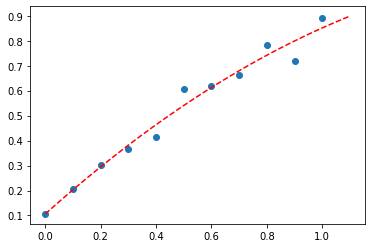

In [ ]:
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(0, 1.1, 0.001)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e)
# create a line plot for the mapping function

plt.scatter(linspace, bdom_means)
plt.plot(x_line, y_line, '--', color='red')
plt.show()

In [ ]:
import time

for i in range(2*60):
    print (i), # print in the same line by adding a "," at the end
    time.sleep(30)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


KeyboardInterrupt: ignored